<a href="https://colab.research.google.com/github/dondonrocket/kokudo/blob/%E5%8B%89%E5%BC%B7%E4%BC%9A/%E5%9B%BD%E5%9C%9F%E4%BA%A4%E9%80%9A%E7%9C%81_%E5%9C%B0%E7%90%86%E7%A9%BA%E9%96%93%E6%83%85%E5%A0%B1%E3%83%86%E3%82%99%E3%83%BC%E3%82%BF%E3%83%81%E3%83%A3%E3%83%AC%E3%83%B3%E3%82%B7%E3%82%99_%E5%9B%BD%E5%9C%9F%E6%95%B0%E5%80%A4%E6%83%85%E5%A0%B1%E7%B7%A8_%E5%8B%89%E5%BC%B7%E4%BC%9A_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 国土交通省 第2回 地理空間情報データチャレンジ ～国土数値情報編～ 勉強会


*   本勉強会はGoogleColabを利用します。初めての方は[Googleのこちらのサイト](https://colab.research.google.com/?hl=ja)を参照ください　※Geminiも便利！
*   本ファイルをご自身のGoogleDriveにコピーして利用ください。
*   勉強会の開始前に[Signateコンペサイト](https://user.competition.signate.jp/ja/competition/detail/?competition=2b0105bc0c674f258e39cb2c7711e36f&leaderboard=public)からデータをダウンロードして、ご自身のGoogleDriveにアップロードしておいてください



# 事前設定

In [ ]:
# Version確認
!python --version

Python 3.12.12


In [ ]:
# ライブラリのインストール（初回のみ）

# グラフに日本語表示させたい場合　*tips python 3.12以降はjapanize-matplotlibの代わりにmatplotlib-fontja
!pip install japanize-matplotlib

# 手軽に全変数をチェックしたい場合
# !pip install -U ydata-profiling

In [ ]:
# ライブラリの読み込み
import os
import scipy as sp
import numpy as np
import sklearn
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font="IPAexGothic") #日本語フォント設定
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from scipy.stats import norm

# グラフをインラインで表示させる
%matplotlib inline

# 表示制限の緩和
pd.set_option('display.max_columns', 300 )
pd.set_option('display.max_rows', 500 )
# 指数表記の無効化
pd.options.display.float_format = '{:.2f}'.format

import japanize_matplotlib #日本語化matplotlib

import lightgbm as lgb
from sklearn.metrics import mean_absolute_percentage_error

from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import train_test_split
import warnings
from google.colab import drive
# from ydata_profiling import ProfileReport



# データ入出力とチェック

In [ ]:
# ローカルPCのファイルをuploadする場合
# from google.colab import files
# uploaded = files.upload()

In [ ]:
# Google Driveにマウントして、ここからデータを読む場合
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# （各自の）Google Drive上のデータ保存先のパスに移動　*下記はMyDrive直下の例
%cd '/content/drive/MyDrive/第2回 国土交通省 地理空間情報データチャレンジ'

/content/drive/MyDrive/第2回 国土交通省 地理空間情報データチャレンジ


In [ ]:
# 対象のCSVデータの読込
df_train_raw = pd.read_csv('./data/train.csv')
df_test_raw = pd.read_csv('./data/test.csv')

/tmp/ipython-input-2139907019.py:2: DtypeWarning: Columns (63) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train_raw = pd.read_csv('./data/train.csv')
/tmp/ipython-input-2139907019.py:3: DtypeWarning: Columns (46,55,56,63,146) have mixed types. Specify dtype option on import or set low_memory=False.
  df_test_raw = pd.read_csv('./data/test.csv')


In [ ]:
# ①データを俯瞰（先頭）
df_train_raw.head()

,target_ym,money_room,building_id,building_status,building_create_date,building_modify_date,building_type,building_name,building_name_ruby,homes_building_name,homes_building_name_ruby,unit_count,full_address,lon,lat,building_structure,total_floor_area,building_area,floor_count,basement_floor_count,year_built,building_land_area,land_area_all,unit_area_min,unit_area_max,building_land_chimoku,land_youto,land_toshi,land_chisei,land_area_kind,land_setback_flg,land_setback,land_kenpei,land_youseki,land_road_cond,land_seigen,building_area_kind,management_form,management_association_flg,reform_exterior,reform_exterior_other,reform_exterior_date,reform_common_area,reform_common_area_date,building_tag_id,unit_id,unit_name,name_ruby,room_floor,balcony_area,dwelling_unit_window_angle,room_count,unit_area,floor_plan_code,reform_date,reform_place,reform_place_other,reform_wet_area,reform_wet_area_other,reform_wet_area_date,reform_interior,reform_interior_other,reform_interior_date,reform_etc,renovation_date,renovation_etc,unit_tag_id,bukken_id,snapshot_create_date,new_date,snapshot_modify_date,timelimit_date,bukken_type,flg_investment,empty_number,empty_contents,post1,post2,addr1_1,addr1_2,addr2_name,addr3_name,nl,el,rosen_name1,eki_name1,bus_stop1,bus_time1,walk_distance1,rosen_name2,eki_name2,bus_stop2,bus_time2,walk_distance2,traffic_other,traffic_car,snapshot_land_area,snapshot_land_shidou,land_shidou_a,land_shidou_b,land_mochibun_a,land_mochibun_b,house_area,flg_new,house_kanrinin,room_kaisuu,snapshot_window_angle,madori_number_all,madori_kind_all,money_kyoueki,money_kyoueki_tax,money_rimawari_now,money_shuuzen,money_shuuzenkikin,money_sonota_str1,money_sonota1,money_sonota_str2,money_sonota2,money_sonota_str3,money_sonota3,parking_money,parking_money_tax,parking_kubun,parking_distance,parking_number,parking_memo,genkyo_code,usable_status,usable_date,school_ele_name,school_ele_distance,school_ele_code,school_jun_name,school_jun_distance,school_jun_code,convenience_distance,super_distance,hospital_distance,park_distance,drugstore_distance,bank_distance,shopping_street_distance,est_other_name,est_other_distance,statuses,parking_keiyaku,money_hoshou_company,free_rent_duration,free_rent_gen_timing
0,201901,13980000,206271,1,2014-06-27 21:09:41,2019-01-24 00:10:08,4,NaN,NaN,桑名市東正和台7丁目10-11,NaN,NaN,三重県桑名市東正和台7丁目10-11,136.64,35.05,1.00,106.82,NaN,2.00,NaN,199204.00,188.49,188.49,NaN,NaN,1.00,1.00,1.00,NaN,1.00,NaN,NaN,50.00,80.00,NaN,NaN,1.00,NaN,NaN,NaN,外壁塗装,201807.00,NaN,NaN,210202/210301/210101,262186,NaN,NaN,NaN,NaN,NaN,4.00,106.82,450.00,NaN,NaN,NaN,1/2/3/4,NaN,201807.00,NaN,畳表替え,201807.00,NaN,NaN,NaN,310501/220701/220601/230401,360840,2018-10-30 00:00:00,2018-10-30 00:00:00,2019-01-22 13:20:11,2019-02-05 00:00:00,1202,NaN,1.00,NaN,511.00,932.00,24,205,東正和台7丁目,NaN,126159934.00,491905398.00,三岐鉄道北勢線,在良,NaN,NaN,1840.00,NaN,NaN,NaN,NaN,NaN,コミュニティバス「東正和台」停より約 500m,NaN,188.49,NaN,NaN,NaN,NaN,NaN,106.82,0.00,NaN,NaN,NaN,4,50,NaN,3.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,1.00,NaN,2.00,NaN,2.00,1,NaN,桑部小学校,2000.00,NaN,正和中学校,2000.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,210101/220701/220601/230401/310501/210301/210202,NaN,NaN,NaN,NaN
1,201901,24480000,83315,1,2014-06-27 21:09:43,2019-04-03 00:10:08,4,NaN,NaN,桑名市松ノ木5丁目,NaN,1.00,三重県桑名市松ノ木5丁目14-8,136.64,35.07,10.00,NaN,NaN,2.00,NaN,198108.00,290.52,NaN,NaN,NaN,NaN,1.00,1.00,1.00,2.00,1.00,1.20,50.00,80.00,1.00,NaN,NaN,NaN,NaN,2,外壁塗装,201706.00,NaN,NaN,330501/210301/210101/210201,35726,NaN,NaN,NaN,NaN,5.00,4.00,134.04,450.00,NaN,NaN,NaN,1/2/3/4,キッチン・ユニットバス・洗面化粧台コーティング/トイレ新品,201706.00,2/4,NaN,201706.00,NaN,2017-06-01,外装外壁塗装 内装システムキッチン新品/お風呂新品/洗面台新品/トイレ新品/フローリング上張...,260201/260301/220801/230601/260101/230101/2203...,267022,2018-10-30 00:00:00,2018-10-30 00:00:00,2019-01-30 15:15:49,2019-02-13 00:00:00,1202,NaN,NaN,NaN,511.00,902.00,24,205,松ノ木5丁目,NaN,126256831.00,491914000.00,三岐鉄道北勢線,星川,NaN,NaN,1920.00,NaN,NaN,NaN,NaN,NaN,コミュニティバス「法務局前」停より約400m,NaN,290.52,NaN,NaN,NaN,NaN,NaN,134.04,0.00,NaN,NaN,

In [ ]:
# ①データを俯瞰（末尾）
df_train_raw.tail(1)

,target_ym,money_room,building_id,building_status,building_create_date,building_modify_date,building_type,building_name,building_name_ruby,homes_building_name,homes_building_name_ruby,unit_count,full_address,lon,lat,building_structure,total_floor_area,building_area,floor_count,basement_floor_count,year_built,building_land_area,land_area_all,unit_area_min,unit_area_max,building_land_chimoku,land_youto,land_toshi,land_chisei,land_area_kind,land_setback_flg,land_setback,land_kenpei,land_youseki,land_road_cond,land_seigen,building_area_kind,management_form,management_association_flg,reform_exterior,reform_exterior_other,reform_exterior_date,reform_common_area,reform_common_area_date,building_tag_id,unit_id,unit_name,name_ruby,room_floor,balcony_area,dwelling_unit_window_angle,room_count,unit_area,floor_plan_code,reform_date,reform_place,reform_place_other,reform_wet_area,reform_wet_area_other,reform_wet_area_date,reform_interior,reform_interior_other,reform_interior_date,reform_etc,renovation_date,renovation_etc,unit_tag_id,bukken_id,snapshot_create_date,new_date,snapshot_modify_date,timelimit_date,bukken_type,flg_investment,empty_number,empty_contents,post1,post2,addr1_1,addr1_2,addr2_name,addr3_name,nl,el,rosen_name1,eki_name1,bus_stop1,bus_time1,walk_distance1,rosen_name2,eki_name2,bus_stop2,bus_time2,walk_distance2,traffic_other,traffic_car,snapshot_land_area,snapshot_land_shidou,land_shidou_a,land_shidou_b,land_mochibun_a,land_mochibun_b,house_area,flg_new,house_kanrinin,room_kaisuu,snapshot_window_angle,madori_number_all,madori_kind_all,money_kyoueki,money_kyoueki_tax,money_rimawari_now,money_shuuzen,money_shuuzenkikin,money_sonota_str1,money_sonota1,money_sonota_str2,money_sonota2,money_sonota_str3,money_sonota3,parking_money,parking_money_tax,parking_kubun,parking_distance,parking_number,parking_memo,genkyo_code,usable_status,usable_date,school_ele_name,school_ele_distance,school_ele_code,school_jun_name,school_jun_distance,school_jun_code,convenience_distance,super_distance,hospital_distance,park_distance,drugstore_distance,bank_distance,shopping_street_distance,est_other_name,est_other_distance,statuses,parking_keiyaku,money_hoshou_company,free_rent_duration,free_rent_gen_timing
363923,202207,33900000,183801,1,2014-06-27 21:09:38,2025-09-15 02:51:02,1,ポレスター桑名弐番館,NaN,ポレスター桑名弐番館,NaN,34.00,三重県桑名市蓮見町41-4,136.69,35.07,4.00,NaN,NaN,9.00,NaN,200409.00,NaN,NaN,NaN,NaN,NaN,6.00,NaN,1.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00,3.00,NaN,NaN,NaN,NaN,NaN,NaN,210101/320101/330501/321001/321101/310101,82024,203,NaN,2.00,22.22,6.00,4.00,100.50,450.00,NaN,NaN,NaN,1/2/3/4,NaN,202210.00,3/4/5,NaN,202210.00,NaN,NaN,NaN,260201/250301/260301/220801/230601/260101/2301...,223097,2022-04-19 00:00:00,2022-04-19 00:00:00,2022-07-25 18:55:47,2022-08-08 00:00:00,1302,0.00,NaN,203,511.00,8.00,24,205,蓮見町,41-4,126240517.00,492089463.00,JR関西本線,桑名,NaN,NaN,1040.00,三岐鉄道北勢線,馬道,NaN,NaN,2080.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.00,0.00,3.00,2.00,NaN,4,50,9420.00,2.00,NaN,10970.00,NaN,ＣＡＴＶ,550.00,NaN,NaN,NaN,NaN,5000.00,NaN,1.00,0.00,NaN,駐車場の空き状況は要確認,2.00,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,331.00,453.00,NaN,NaN,505.00,NaN,NaN,厚生館保育所,489.00,220201/321001/210101/230501/220301/290401/2534...,2.00,NaN,NaN,NaN


In [ ]:
#②データの行数・列数は正しいか？（テキストエディタなどで開いて確認）
df_train_raw.shape

(363924, 149)

In [ ]:
#③データ型は正しいか？（量的変数/質的変数、日付など）
#参照 第1回勉強会資料　https://docs.google.com/presentation/d/1loX_LdIawac6FA84VQ57RPk8YYDnphxpgjOndRTuCww/edit#slide=id.g30e8b882d1d_0_578
df_train_raw.dtypes

,0
target_ym,int64
money_room,int64
building_id,int64
building_status,int64
building_create_date,object
building_modify_date,object
building_type,int64
building_name,object
building_name_ruby,float64
homes_building_name,object


# 前処理





*   データセットを事前に絞込　*立地×建物/部屋×時期
*   （必要に応じてサンプリングでデータ件数を縮小）



In [ ]:
# 対象カラムをリストで指定
target_columns = ['target_ym','money_room','building_type','building_structure','madori_kind_all','floor_count','year_built','house_area','unit_area','addr1_1','addr1_2','post1','walk_distance1','lat','lon']
# 対象カラムを絞り込み
df_train = df_train_raw[target_columns].copy()
# 抽出結果を表示
df_train.head(2)

,target_ym,money_room,building_type,building_structure,madori_kind_all,floor_count,year_built,house_area,unit_area,addr1_1,addr1_2,post1,walk_distance1,lat,lon
0,201901,13980000,4,1.00,50,2.00,199204.00,106.82,106.82,24,205,511.00,1840.00,35.05,136.64
1,201901,24480000,4,10.00,50,2.00,198108.00,134.04,134.04,24,205,511.00,1920.00,35.07,136.64


In [ ]:
# int型_NaNを埋めてから整数型に変換（0や99など変数にあわせて設定）
df_train['target_ym'] = df_train['target_ym'].fillna(0).astype(int)
df_train['money_room'] = df_train['money_room'].fillna(0).astype(int)
df_train['floor_count'] = df_train['floor_count'].fillna(0).astype(int)
df_train['walk_distance1'] = df_train['walk_distance1'].fillna(9999).astype(int)

# float型に変換
df_train['unit_area'] = df_train['unit_area'].fillna(0).astype(float)

# 2025年からの経過年数に変換(先頭4文字を取得)
df_train['completion_year']=df_train['year_built'].astype(float)
df_train['year_built'] = df_train['year_built'].fillna('199000').astype(str)
df_train['year_built'] = df_train['year_built'].astype(str).str[:4].astype(int)
df_train['year_built'] = 2025 - df_train['year_built']

# object型のでnanを欠損値処理
df_train = df_train.fillna('NA')

# 0埋め
df_train['addr1_1'] = df_train['addr1_1'].astype(str).str.zfill(2)
# NA以外を0埋め
# df_train.loc[df_train['post1'] != 'NA', 'post1'] = df_train.loc[df_train['post1'] != 'NA', 'post1'].str.zfill(3)

In [ ]:
df_train.head()

,target_ym,money_room,building_type,building_structure,madori_kind_all,floor_count,year_built,house_area,unit_area,addr1_1,addr1_2,post1,walk_distance1,lat,lon,completion_year
0,201901,13980000,4,1.00,50,2,33,106.82,106.82,24,205,511.00,1840,35.05,136.64,199204.00
1,201901,24480000,4,10.00,50,2,44,134.04,134.04,24,205,511.00,1920,35.07,136.64,198108.00
2,201901,24480000,4,1.00,50,2,30,114.59,114.59,24,205,511.00,2000,35.07,136.64,199506.00
3,201901,16300000,4,1.00,50,2,23,106.81,106.81,23,224,478.00,480,35.00,136.88,200203.00
4,201901,18800000,1,4.00,50,6,18,76.74,76.74,23,224,478.00,320,35.00,136.88,200703.00


In [ ]:
# testにも同じ処理を適用
# 対象カラムをリストで指定
target_columns = ['target_ym','building_type','building_structure','madori_kind_all','floor_count','year_built','house_area','unit_area','addr1_1','addr1_2','post1','walk_distance1','lat','lon']
# 対象カラムを絞り込み
df_test = df_test_raw[target_columns].copy()

# 正しいデータ型に変換_test

# int型_NaNを埋めてから整数型に変換（0や99など変数にあわせて設定）
df_test['target_ym'] = df_test['target_ym'].fillna(0).astype(int)
df_test['floor_count'] = df_test['floor_count'].fillna(0).astype(int)
df_test['walk_distance1'] = df_test['walk_distance1'].fillna(9999).astype(int)

# float型に変換
df_test['unit_area'] = df_test['unit_area'].fillna(0).astype(float)

# 2025年からの経過年数に変換(先頭4文字を取得)
df_test['completion_year']=df_test['year_built'].astype(float)
df_test['year_built'] = df_test['year_built'].fillna('199000').astype(str)
df_test['year_built'] = df_test['year_built'].astype(str).str[:4].astype(int)
df_test['year_built'] = 2025 - df_test['year_built']

# object型のでnanを欠損値処理
df_test = df_test.fillna('NA')

# 0埋め
df_test['addr1_1'] = df_test['addr1_1'].astype(str).str.zfill(2)
# NA以外を0埋め
# df_test.loc[df_test['post1'] != 'NA', 'post1'] = df_test.loc[df_test['post1'] != 'NA', 'post1'].str.zfill(3)

## 予測のためのデータ分割（バリデーション）

In [ ]:
# 2022年とそれ以外に分類
df_train_2022=df_train[df_train['target_ym'].astype(str).str[:4]=='2022']
df_train_other=df_train[df_train['target_ym'].astype(str).str[:4]!='2022']

In [ ]:
df_train_2022.shape

(89566, 16)

In [ ]:
df_train_other.shape

(274358, 16)

# 基本統計量と集計・可視化

## 目的変数（money_room）

In [ ]:
# 基本統計量
df_train['money_room'].describe()

,money_room
count,363924.00
mean,25925082.06
std,18572852.75
min,4900000.00
25%,13990000.00
50%,21800000.00
75%,32300000.00
max,188000000.00


<Axes: xlabel='money_room', ylabel='Count'>

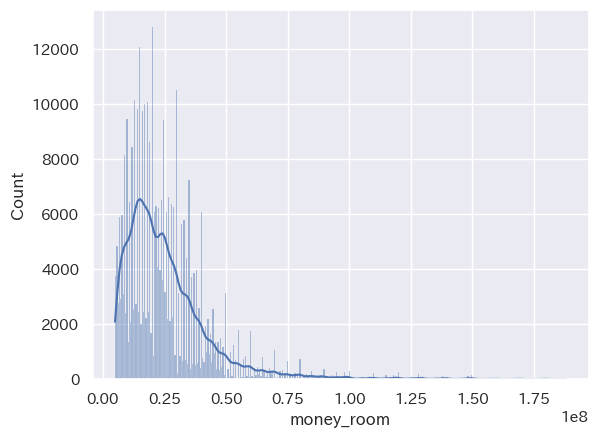

In [ ]:
# 可視化（分布：ヒストグラム）
sns.histplot(df_train['money_room'], kde=True)

In [ ]:
# 基本統計量：都道府県別の価格を比較
df_train.groupby('addr1_1')['money_room'].describe()

,count,mean,std,min,25%,50%,75%,max
addr1_1,,,,,,,,
01,6027.00,19381743.82,11877855.41,4900000.00,11990000.00,16800000.00,24650000.00,178000000.00
02,638.00,15831003.13,6696066.56,4900000.00,11790000.00,14545000.00,18395000.00,45000000.00
03,511.00,18648708.41,9289336.13,4900000.00,11980000.00,16900000.00,23245000.00,65000000.00
04,6034.00,22430662.74,13002556.65,4900000.00,14500000.00,19800000.00,26900000.00,164000000.00
05,347.00,16784172.91,7050586.98,5000000.00,12150000.00,15790000.00,20300000.00,53000000.00
06,351.00,19864370.37,9133251.63,4900000.00,12990000.00,17990000.00,24890000.00,55550000.00
07,1734.00,20518091.12,9375441.30,4900000.00,14792500.00,19500000.00,24997500.00,88000000.00
08,5525.00,18014862.08,11569859.12,4900000.00,9980000.00,15600000.00,22800000.00,170000000.00
09,2963.00,18503842.05,10381715.44,4900000.00,11990000.00,16000000.00,22900000.00,120000000.00


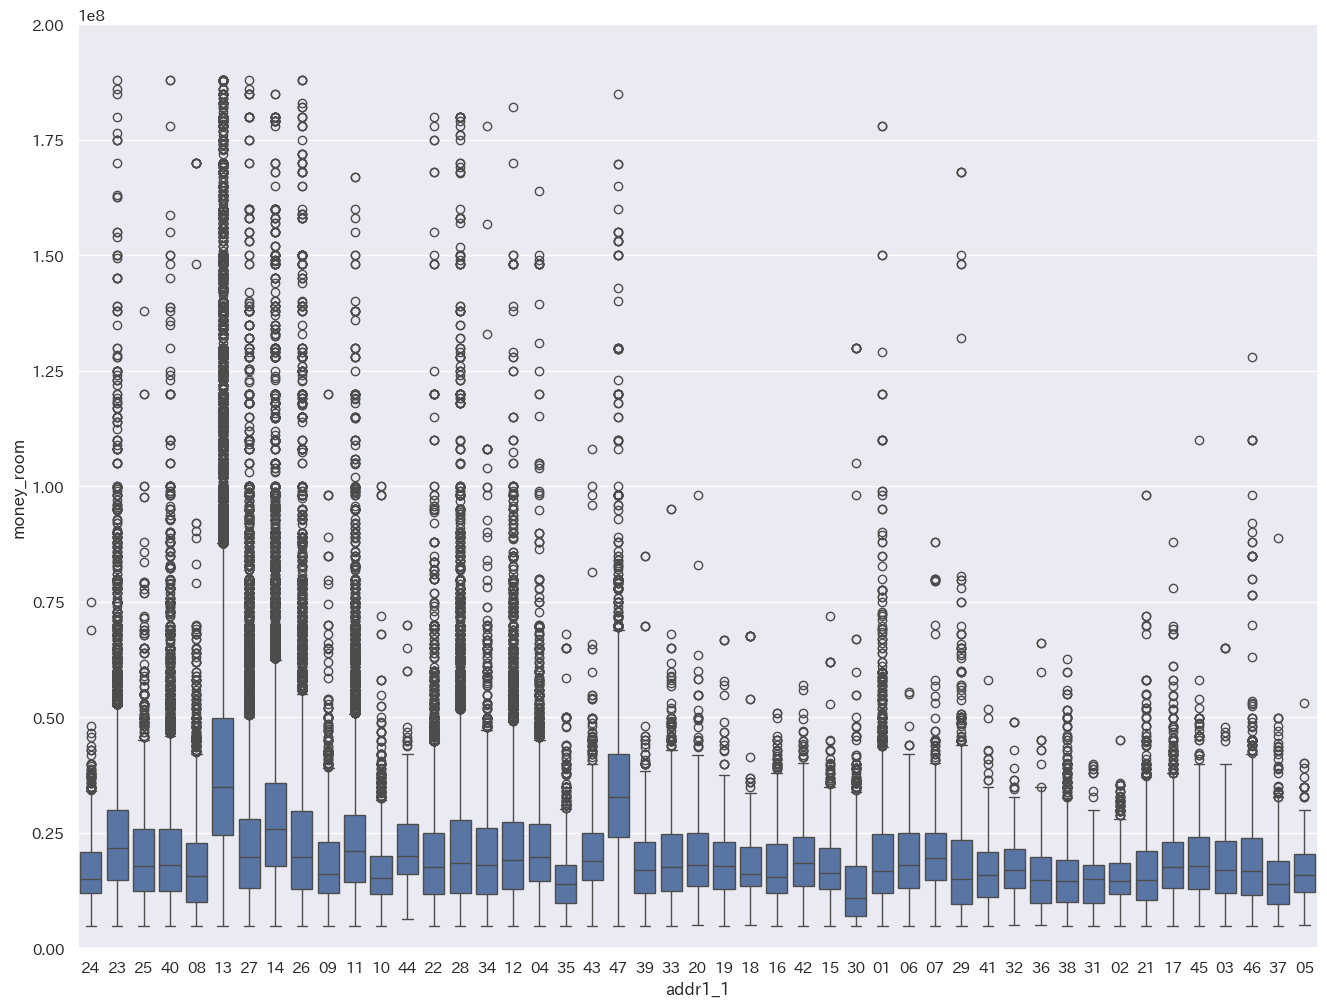

In [ ]:
# 箱ひげ図：都道府県別の価格
var = 'addr1_1'
data = pd.concat([df_train['money_room'], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 12))
fig = sns.boxplot(x=var, y="money_room", data=data)
fig.axis(ymin=0, ymax=200000000);

### 価格の推移（中央値）

   target_ym  year
0     201901  2019
1     201901  2019
2     201901  2019
3     201901  2019
4     201901  2019
year
2019   21000000.00
2020   21600000.00
2021   21800000.00
2022   23500000.00
Name: money_room, dtype: float64


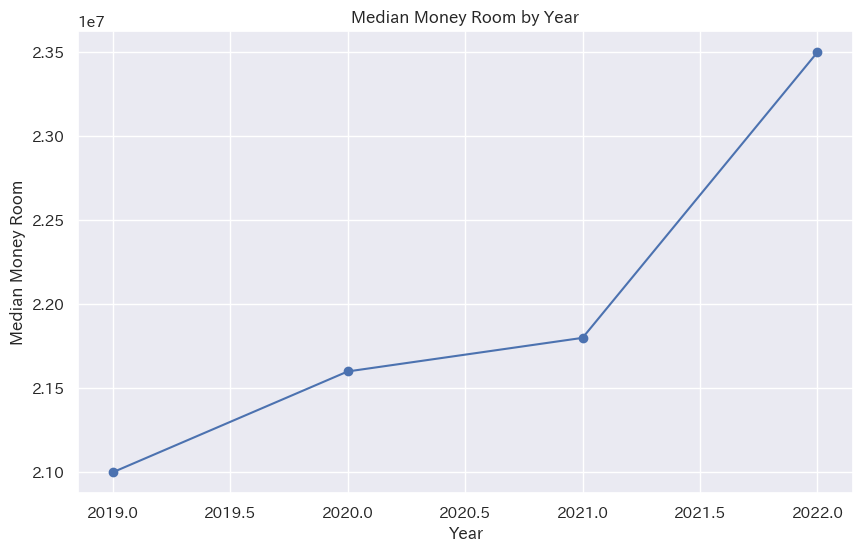

In [ ]:
# 売買価格の推移
df_train['year'] = df_train['target_ym'].astype(str).str[:4].astype(int)
print(df_train[['target_ym', 'year']].head())
yearly_median_money_room = df_train.groupby('year')['money_room'].median()
print(yearly_median_money_room)
plt.figure(figsize=(10, 6))
yearly_median_money_room.plot(kind='line', marker='o')
plt.title('Median Money Room by Year')
plt.xlabel('Year')
plt.ylabel('Median Money Room')
plt.grid(True)
plt.show()

## 説明変数

In [ ]:
df_train.head(2)

,target_ym,money_room,building_type,building_structure,madori_kind_all,floor_count,year_built,house_area,unit_area,addr1_1,addr1_2,post1,walk_distance1,lat,lon,completion_year,year
0,201901,13980000,4,1.00,50,2,33,106.82,106.82,24,205,511.00,1840,35.05,136.64,199204.00,2019
1,201901,24480000,4,10.00,50,2,44,134.04,134.04,24,205,511.00,1920,35.07,136.64,198108.00,2019


## （予測のための）前処理・・・相関が高い 面積、築年、エリアを対象

unit_area

In [ ]:
# unit_area>=1000以上を表示
df_train[df_train['unit_area'] >= 1000]

,target_ym,money_room,building_type,building_structure,madori_kind_all,floor_count,year_built,house_area,unit_area,addr1_1,addr1_2,post1,walk_distance1,lat,lon,completion_year,year
8021,201901,49800000,4,9.00,50,3,15,19387.00,19387.00,28,202,661.00,240,34.75,135.45,201012.00,2019
9141,201901,31800000,4,1.00,50,2,7,174.54,16023.00,11,201,350.00,1280,35.93,139.43,201812.00,2019
14601,201901,15800000,4,NA,50,2,21,7066.00,7066.00,14,203,259.00,160,35.35,139.32,200408.00,2019
17795,201901,6500000,1,5.00,10,12,33,2642.13,2642.13,13,205,198.00,320,35.79,139.26,199211.00,2019
18753,201901,9800000,4,1.00,50,1,21,1162.93,1162.93,21,205,501.00,240,35.59,136.84,200409.00,2019
40242,201907,5300000,4,10.00,50,2,30,1337.94,1337.94,35,201,759.00,880,34.31,130.91,199501.00,2019
46729,201907,49800000,4,9.00,50,3,15,19387.00,19387.00,28,202,661.00,240,34.75,135.45,201012.00,2019
47405,201907,8880000,4,9.00,50,1,44,1711.34,1711.34,25,212,520.00,2400,35.42,136.02,198110.00,2019
47521,201907,29800000,4,3.00,50,3,50,1042.37,1042.37,07,204,970.00,11920,36.97,140.96,197501.00,2019
48133,201907,26800000,4,1.00,50,2,7,174.54,16023.00,11,201,350.00,1280,35.93,139.43,201812.00,2019


In [ ]:
# df_train['unit_area']が1000以上のデータを削除
df_train_other=df_train_other.loc[(df_train_other['unit_area'] <= 1000)]
df_train=df_train.loc[(df_train['unit_area'] <= 1000)]

In [ ]:
df_train_other.shape

(274331, 16)

year_built

In [ ]:
df_train['year_built'].describe()

,year_built
count,363892.00
mean,31.72
std,14.13
min,-9.00
25%,22.00
50%,32.00
75%,42.00
max,525.00


In [ ]:
# year_builtが150以上を表示　*日本で一番古いマンションは築７０年前後(戸建てがデータに存在するため)
df_train[df_train['year_built'] > 150]

,target_ym,money_room,building_type,building_structure,madori_kind_all,floor_count,year_built,house_area,unit_area,addr1_1,addr1_2,post1,walk_distance1,lat,lon,completion_year,year
98537,202001,13500000,4,1.00,30,1,157,102.11,102.11,25,202,522.00,240,35.27,136.25,186801.00,2020
128723,202001,11800000,4,1.00,35,2,157,92.88,92.88,26,110,607.00,640,35.00,135.79,186801.00,2020
136960,202007,29800000,4,1.00,10,1,225,125.11,125.11,26,104,604.00,800,35.02,135.74,180001.00,2020
144860,202007,7800000,4,1.00,30,1,525,96.52,96.52,26,111,610.00,9999,34.97,135.62,150001.00,2020
150227,202007,13500000,4,1.00,30,1,157,102.11,102.11,25,202,522.00,240,35.27,136.25,186801.00,2020
170338,202007,12000000,4,1.00,30,1,157,180.18,180.18,40,107,803.00,1040,33.79,130.86,186801.00,2020
189452,202101,6800000,4,1.00,30,1,157,116.36,116.36,35,201,751.00,1680,33.97,130.93,186801.00,2021
195727,202101,5900000,4,1.00,30,1,525,96.52,96.52,26,111,610.00,9999,34.97,135.62,150001.00,2021
200139,202101,13500000,4,1.00,30,1,157,102.11,102.11,25,202,522.00,240,35.27,136.25,186801.00,2021
227205,202101,10500000,4,1.00,35,2,157,92.88,92.88,26,110,607.00,640,35.00,135.79,186801.00,2021


In [ ]:
# year_builtが150以上または0年未満の物件を、削除
df_train_other=df_train_other.loc[(df_train_other['year_built'] <= 150) & (df_train_other['year_built'] >=0)]
df_train=df_train.loc[(df_train['year_built'] <= 150) & (df_train['year_built'] >=0)]

floor_count

In [ ]:
# floor_countが70以上を表示 *日本で一番高いマンションは64階
df_train[df_train['floor_count'] > 70]

,target_ym,money_room,building_type,building_structure,madori_kind_all,floor_count,year_built,house_area,unit_area,addr1_1,addr1_2,post1,walk_distance1,lat,lon,completion_year,year
193292,202101,10980000,4,1.00,30,898,31,97.97,97.97,16,202,933.00,1680,36.74,137.04,199408.00,2021
238067,202107,8980000,4,1.00,30,898,31,97.97,97.97,16,202,933.00,1840,36.74,137.04,199408.00,2021
260522,202107,9800000,4,1.00,30,980,30,91.49,91.49,28,210,675.00,640,34.73,134.85,199503.00,2021


In [ ]:
# floor_countが70以上の物件を削除
df_train_other=df_train_other.loc[(df_train_other['floor_count'] <= 70)]
df_train=df_train.loc[(df_train['floor_count'] <= 70)]

In [ ]:
# 建物構造を見る
df_train['building_structure'].value_counts()
# 1:木造 2:ブロック 3:鉄骨造 4:RC 5:SRC 6:PC 7:HPC 9:その他 10:軽量鉄骨 11:ALC 12:鉄筋ブロック 13:CFT(コンクリート充填鋼管)

,count
building_structure,
4.00,138553
1.00,131685
5.00,57655
NA,15448
10.00,10967
3.00,7170
9.00,2171
2.00,101
6.00,64


In [ ]:
# 間取りを見る
df_train['madori_kind_all'].value_counts()
# 10:R 20:K 25:SK 30:DK 35:SDK 40:LK 45:SLK 50:LDK 55:SLDK その他: 欠損

,count
madori_kind_all,
50,253756
30,44294
55,41848
20,12101
10,6601
35,4471
25,447
40,187
45,140


# 決定木での予測

Validation MAPE: 0.2041 (20.41%)


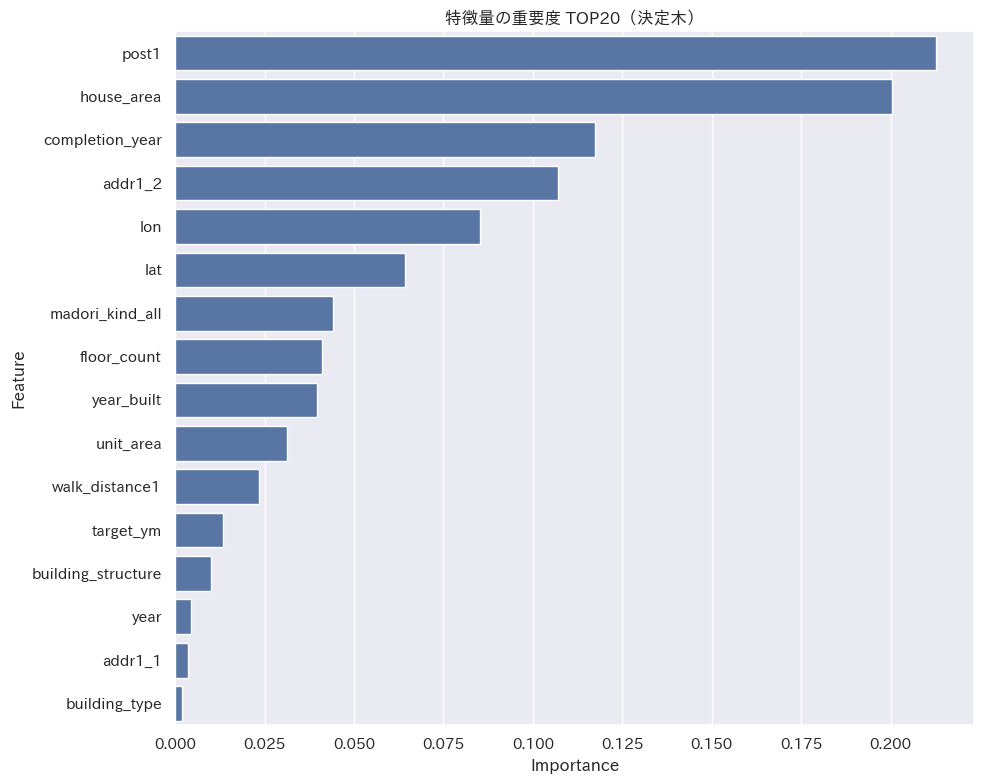


予測結果の先頭5行:


,money_room
0,15800000.00
1,27900000.00
2,9480000.00
3,28000000.00
4,13990000.00


In [ ]:
# データを加工用にコピー
train_df = df_train.copy()
test_df = df_test.copy()

# 学習用とテスト用を区別するフラグを立てる
train_df['is_train'] = 1
test_df['is_train'] = 0

# テストデータには目的変数(money_room)がないため、一時的に0を入れて列を合わせる
test_df['money_room'] = 0

# 学習データとテストデータを縦に結合（カテゴリ変数をまとめて変換するため）
all_df = pd.concat([train_df, test_df], axis=0, ignore_index=True)

# カテゴリ変数をLabel Encoding
cat_cols = all_df.select_dtypes(include=['object']).columns
for col in cat_cols:
    le = LabelEncoder()
    # 欠損値を文字列'nan'として扱い、全データを変換
    all_df[col] = le.fit_transform(all_df[col].astype(str))

# エンコーディングが終わったら、再度学習用とテスト用に分割
train_encoded = all_df[all_df['is_train'] == 1].drop(['is_train'], axis=1)
test_encoded = all_df[all_df['is_train'] == 0].drop(['is_train', 'money_room'], axis=1)

# --- モデル学習フェーズ ---

# 説明変数(X)と目的変数(y)
X = train_encoded.drop('money_room', axis=1)
y = train_encoded['money_room']

# 学習データと検証データに分割 (8:2)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# モデル定義と学習
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train, y_train)

# 検証データでの精度確認
y_pred_valid = dt_model.predict(X_valid)
mape = mean_absolute_percentage_error(y_valid, y_pred_valid)
print(f'Validation MAPE: {mape:.4f} ({mape:.2%})')

# --- 特徴量重要度の可視化 ---

# 重要度をデータフレーム化してソート
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': dt_model.feature_importances_
}).sort_values('importance', ascending=False)

# 上位20個を表示
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=importance_df.head(20))
plt.title('特徴量の重要度 TOP20（決定木）')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# --- 予測フェーズ (df_test) ---

# テストデータを使って予測
y_pred_test = dt_model.predict(test_encoded)

# 予測結果を元のテストデータフレーム（のコピー）に追加して確認
df_submit = df_test.copy()
df_submit['money_room'] = y_pred_test

# 予測値に負の値がないか確認（念のため0以下をクリップなどしても良い）
print("\n予測結果の先頭5行:")
display(df_submit[['money_room']].head())

# 必要であればCSVに出力
df_submit.to_csv('submission_dt.csv', index=False)

# LightGBMでの予測

In [ ]:
#使用するデータフレームをコピー
df_train_light_gbm=df_train_other.copy()

In [ ]:
# レコードの確認
df_train_light_gbm.head(2)

,target_ym,money_room,building_type,building_structure,madori_kind_all,floor_count,year_built,house_area,unit_area,addr1_1,addr1_2,post1,walk_distance1,lat,lon,completion_year
0,201901,13980000,4,1.00,50,2,33,106.82,106.82,24,205,511.00,1840,35.05,136.64,199204.00
1,201901,24480000,4,10.00,50,2,44,134.04,134.04,24,205,511.00,1920,35.07,136.64,198108.00


## モデル構築 *ベースモデル

In [ ]:
#予測する関数を定義
def train_and_predict(df_train_other, df_train_2022, model_name="Default"):
    # 説明変数と目的変数の分離
    df_x_train = df_train_other.drop(['money_room','completion_year'], axis=1).copy()
    df_y_train = df_train_other['money_room'].astype(int)
    df_x_test  = df_train_2022.drop(['money_room','completion_year'], axis=1).copy()
    df_y_test  = df_train_2022['money_room'].astype(int)

    # エンコード処理
    label_encoder = LabelEncoder()
    encode_cols = ['building_type', 'building_structure',
                  'addr1_1','addr1_2','post1','madori_kind_all']

    for col in encode_cols:
        if col in df_x_train.columns:
            all_values = pd.concat([df_x_train[col], df_x_test[col]]).astype(str)
            label_encoder.fit(all_values)
            df_x_train[col] = label_encoder.transform(df_x_train[col].astype(str))
            df_x_test[col] = label_encoder.transform(df_x_test[col].astype(str))

    # 数値変換
    for col in ['lat', 'lon', 'house_area']:
        if col in df_x_train.columns:
            df_x_train[col] = df_x_train[col].astype(float)
            df_x_test[col] = df_x_test[col].astype(float)

    # year, target_ymがあれば削除
    for df_ in [df_x_train, df_x_test]:
        for col in ['year', 'target_ym']:
            if col in df_.columns:
                df_.drop(col, axis=1, inplace=True)

    # データが少なすぎて学習できない場合のガード
    if len(df_x_train) == 0 or len(df_x_test) == 0:
        print(f"[{model_name}] データ不足のためスキップします")
        return None, None

    # LightGBMデータセット
    lgb_train = lgb.Dataset(df_x_train, df_y_train)
    lgb_eval  = lgb.Dataset(df_x_test, df_y_test, reference=lgb_train)

    params = {
        'objective': 'regression',
        'metric': 'mape',
        'boosting_type': 'gbdt',
        'num_leaves': 31,
        'verbose': -1,
        'random_state': 42
    }

    # 学習
    model = lgb.train(
        params,
        lgb_train,
        valid_sets=[lgb_train, lgb_eval],
        valid_names=['train', 'eval'],
        num_boost_round=1000,
        callbacks=[lgb.log_evaluation(0)]
    )

    # 予測
    y_pred = model.predict(df_x_test)

    mape = mean_absolute_percentage_error(df_y_test, y_pred)
    print(f"[{model_name}] MAPE: {mape * 100:.2f}% (件数: {len(df_y_test)})")

    return df_y_test, y_pred

In [ ]:
# ベースとなるモデルの実行
print("ベースモデル")
y_test, y_pred = train_and_predict(df_train_light_gbm, df_train_2022)

ベースモデル
[Default] MAPE: 21.72% (件数: 89566)


## Tips1：㎡価格

In [ ]:
df_train_light_gbm_per_sqm=df_train_other.copy()
df_train_2022_per_sqm=df_train_2022.copy()
# 学習用データ（df_train_other）の平米価格
df_train_light_gbm_per_sqm = df_train_other.copy()
df_train_light_gbm_per_sqm['house_area'] = df_train_light_gbm_per_sqm['house_area'].astype(float)
df_train_light_gbm_per_sqm['price_per_sqm'] = df_train_light_gbm_per_sqm['money_room'] / df_train_light_gbm_per_sqm['house_area']

# テスト用データ（df_train_2022）
df_train_2022_per_sqm['house_area'] = df_train_2022_per_sqm['house_area'].astype(float)
df_train_2022_per_sqm['price_per_sqm'] = df_train_2022_per_sqm['money_room'] / df_train_2022_per_sqm['house_area']


In [ ]:
# 関数作成
def train_and_predict(df_train_other, df_train_2022, model_name="Default"):
    # 説明変数から 'money_room' と 'price_per_sqm' を除外
    df_x_train = df_train_other.drop(['money_room', 'price_per_sqm','completion_year'], axis=1).copy()
    df_y_train = df_train_other['price_per_sqm'].astype(float)

    # テストデータからも 'price_per_sqm' を除外してリークを防ぐ
    df_x_test = df_train_2022.drop(['money_room', 'price_per_sqm','completion_year'], axis=1).copy()
    df_y_test = df_train_2022['price_per_sqm'].astype(float)

    # エンコード処理
    label_encoder = LabelEncoder()
    encode_cols = ['building_type', 'building_structure',
                  'addr1_1','addr1_2','post1','madori_kind_all']

    for col in encode_cols:
        if col in df_x_train.columns:
            all_values = pd.concat([df_x_train[col], df_x_test[col]]).astype(str)
            label_encoder.fit(all_values)
            df_x_train[col] = label_encoder.transform(df_x_train[col].astype(str))
            df_x_test[col] = label_encoder.transform(df_x_test[col].astype(str))

    # 数値変換
    for col in ['lat', 'lon', 'house_area']:
        if col in df_x_train.columns:
            df_x_train[col] = df_x_train[col].astype(float)
            df_x_test[col] = df_x_test[col].astype(float)

    # 不要カラム削除
    for df_ in [df_x_train, df_x_test]:
        for col in ['year', 'target_ym']:
            if col in df_.columns:
                df_.drop(col, axis=1, inplace=True)

    if len(df_x_train) == 0 or len(df_x_test) == 0:
        print(f"[{model_name}] データ不足のためスキップします")
        return None, None

    # LightGBMデータセット
    lgb_train = lgb.Dataset(df_x_train, df_y_train)
    lgb_eval = lgb.Dataset(df_x_test, df_y_test, reference=lgb_train)

    params = {
        'objective': 'regression',
        'metric': 'mape',
        'boosting_type': 'gbdt',
        'num_leaves': 31,
        'verbose': -1,
        'random_state': 42
    }

    model = lgb.train(
        params,
        lgb_train,
        valid_sets=[lgb_train, lgb_eval],
        valid_names=['train', 'eval'],
        num_boost_round=1000,
        callbacks=[lgb.log_evaluation(100)] # ログを少し抑制
    )

    # 予測 (平米価格が出力される)
    y_pred_sqm = model.predict(df_x_test)

    # 平米価格 × 面積 で売買価格に戻す
    y_pred_total_price = y_pred_sqm * df_x_test['house_area']

    # 正解データも処理を統一
    y_true_total_price = df_y_test * df_x_test['house_area']

    mape = mean_absolute_percentage_error(y_true_total_price, y_pred_total_price)
    print(f"[{model_name}] Total Price MAPE: {mape * 100:.2f}% (件数: {len(df_y_test)})")

    return y_true_total_price, y_pred_total_price

In [ ]:
# ㎡価格を使用したモデルの実行
print("\n--- Tips1:㎡価格予測モデル 学習開始 ---")
y_test, y_pred = train_and_predict(df_train_light_gbm_per_sqm, df_train_2022_per_sqm)


--- Tips1:㎡価格予測モデル 学習開始 ---
[100]	train's mape: 0.283626	eval's mape: 0.261003
[200]	train's mape: 0.256741	eval's mape: 0.247492
[300]	train's mape: 0.243072	eval's mape: 0.241875
[400]	train's mape: 0.234993	eval's mape: 0.238247
[500]	train's mape: 0.225559	eval's mape: 0.235483
[600]	train's mape: 0.221443	eval's mape: 0.233639
[700]	train's mape: 0.215454	eval's mape: 0.232292
[800]	train's mape: 0.209758	eval's mape: 0.230483
[900]	train's mape: 0.206001	eval's mape: 0.22844
[1000]	train's mape: 0.204208	eval's mape: 0.227267
[Default] Total Price MAPE: 22.73% (件数: 89566)


## Tips2：MAPE対応

In [ ]:
# mapeようにデータフレームを作成
df_light_gbm_mape=df_train_other.copy()
df_train_2022_mape=df_train_2022.copy()

In [ ]:
# 関数の作成
def train_and_predict(df_train_other, df_train_2022, model_name="LogFairModel"):
    # 説明変数の分離
    df_x_train = df_train_other.drop(['money_room','completion_year'], axis=1).copy()
    df_x_test  = df_train_2022.drop(['money_room','completion_year'], axis=1).copy()

    # 目的変数を対数変換する (Log Transformation)
    # 価格の分布を正規分布に近づけ、学習を安定させます
    df_y_train = np.log1p(df_train_other['money_room'].astype(float))

    # テストデータの正解も対数化（評価時のreference用）
    df_y_test_log = np.log1p(df_train_2022['money_room'].astype(float))

    # エンコード処理
    label_encoder = LabelEncoder()
    encode_cols = ['building_type', 'building_structure',
                  'addr1_1','addr1_2','post1','madori_kind_all']

    for col in encode_cols:
        if col in df_x_train.columns:
            # TrainとTestに含まれる全値を把握してFitさせる
            all_values = pd.concat([df_x_train[col], df_x_test[col]]).astype(str)
            label_encoder.fit(all_values)
            df_x_train[col] = label_encoder.transform(df_x_train[col].astype(str))
            df_x_test[col] = label_encoder.transform(df_x_test[col].astype(str))

    # 数値変換
    for col in ['lat', 'lon', 'house_area']:
        if col in df_x_train.columns:
            df_x_train[col] = df_x_train[col].astype(float)
            df_x_test[col] = df_x_test[col].astype(float)

    # 不要カラム削除
    for df_ in [df_x_train, df_x_test]:
        for col in ['year', 'target_ym']:
            if col in df_.columns:
                df_.drop(col, axis=1, inplace=True)

    if len(df_x_train) == 0 or len(df_x_test) == 0:
        print(f"[{model_name}] データ不足のためスキップします")
        return None, None

    lgb_train = lgb.Dataset(df_x_train, df_y_train)
    lgb_eval  = lgb.Dataset(df_x_test, df_y_test_log, reference=lgb_train)

    # Fair Loss を使用する設定
    params = {
        'objective': 'fair',      # 外れ値に頑健なFair Lossを指定
        'metric': 'rmse',         # 対数空間でのRMSE（実空間でのMAPE改善に寄与）
        'boosting_type': 'gbdt',
        'num_leaves': 31,
        'fair_c': 0.1,            # Fair Lossのパラメータ
        'verbose': -1,
        'random_state': 42
    }

    model = lgb.train(
        params,
        lgb_train,
        valid_sets=[lgb_train, lgb_eval],
        valid_names=['train', 'eval'],
        num_boost_round=1000,
        callbacks=[lgb.log_evaluation(100)]
    )

    # 予測
    y_pred_log = model.predict(df_x_test)

    # 対数から元の金額に戻す
    y_pred = np.expm1(y_pred_log)

    # 正解データ（元のmoney_roomを使用）
    y_true = df_train_2022['money_room'].astype(float)

    # 実金額ベースでのMAPEを表示
    mape = mean_absolute_percentage_error(y_true, y_pred)
    print(f"[{model_name}] MAPE: {mape * 100:.2f}% (件数: {len(y_true)})")

    return y_true, y_pred

In [ ]:
# 学習
print("\n--- 学習開始（Log + Fair Loss） ---")
y_test, y_pred = train_and_predict(df_light_gbm_mape, df_train_2022_mape)

# 結果表示
total_mape = mean_absolute_percentage_error(y_test, y_pred)
print("\n" + "="*40)
print(f"Tips2 ：MAPE対応のMAPE: {total_mape * 100:.2f}%")
print("="*40)


--- 学習開始（Log + Fair Loss） ---
[100]	train's rmse: 0.295106	eval's rmse: 0.322791
[200]	train's rmse: 0.276406	eval's rmse: 0.308916
[300]	train's rmse: 0.265792	eval's rmse: 0.302262
[400]	train's rmse: 0.258437	eval's rmse: 0.297989
[500]	train's rmse: 0.252722	eval's rmse: 0.295081
[600]	train's rmse: 0.247782	eval's rmse: 0.292667
[700]	train's rmse: 0.243568	eval's rmse: 0.290786
[800]	train's rmse: 0.239834	eval's rmse: 0.289183
[900]	train's rmse: 0.236443	eval's rmse: 0.28761
[1000]	train's rmse: 0.233238	eval's rmse: 0.286303
[LogFairModel] MAPE: 20.87% (件数: 89566)

Tips2 ：MAPE対応のMAPE: 20.87%


## Tips3：建物種類別モデル

In [ ]:
# building_typeごとに分けるためのデータフレームの作成
df_light_gbm_bldg_type=df_train_other.copy()
df_train_2022_bldg_type=df_train_2022.copy()

In [ ]:
# 関数の作成
def train_and_predict(df_train, df_test, model_name="Default"):

    # 説明変数と目的変数の分離
    # 不要なカラムや、答え(money_room)を削除
    drop_cols = ['money_room', 'year', 'target_ym','completion_year']
    df_x_train = df_train.drop(drop_cols, axis=1, errors='ignore').copy()
    df_y_train = df_train['money_room'].astype(int)

    df_x_test  = df_test.drop(drop_cols, axis=1, errors='ignore').copy()
    df_y_test  = df_test['money_room'].astype(int)

    # エンコード処理
    label_encoder = LabelEncoder()
    encode_cols = ['building_type', 'building_structure',
                  'addr1_1','addr1_2','post1','madori_kind_all']

    for col in encode_cols:
        if col in df_x_train.columns:
            # 未知ラベル対策: trainとtestを合わせて学習
            all_values = pd.concat([df_x_train[col], df_x_test[col]]).astype(str)
            label_encoder.fit(all_values)
            df_x_train[col] = label_encoder.transform(df_x_train[col].astype(str))
            df_x_test[col] = label_encoder.transform(df_x_test[col].astype(str))

    # 数値変換
    for col in ['lat', 'lon', 'house_area']:
        if col in df_x_train.columns:
            df_x_train[col] = df_x_train[col].astype(float)
            df_x_test[col] = df_x_test[col].astype(float)

    #カラムの整合性を確保（前の実験のカラム残り対策）
    common_cols = [c for c in df_x_train.columns if c in df_x_test.columns]
    df_x_train = df_x_train[common_cols]
    df_x_test  = df_x_test[common_cols]

    # データ不足ガード
    if len(df_x_train) == 0 or len(df_x_test) == 0:
        print(f"[{model_name}] データ不足のためスキップします")
        return None, None

    # LightGBMデータセット
    lgb_train = lgb.Dataset(df_x_train, df_y_train)
    lgb_eval  = lgb.Dataset(df_x_test, df_y_test, reference=lgb_train)

    params = {
        'objective': 'regression',
        'metric': 'mape',
        'boosting_type': 'gbdt',
        'num_leaves': 31,
        'verbose': -1,
        'random_state': 42
    }

    # 学習
    model = lgb.train(
        params,
        lgb_train,
        valid_sets=[lgb_train, lgb_eval],
        valid_names=['train', 'eval'],
        num_boost_round=1000,
        callbacks=[lgb.log_evaluation(100)]
    )

    # 予測
    y_pred = model.predict(df_x_test)

    # このモデル単体でのMAPEを表示
    mape = mean_absolute_percentage_error(df_y_test, y_pred)
    print(f"[{model_name}] MAPE: {mape * 100:.2f}% (件数: {len(df_y_test)})")

    return df_y_test, y_pred



In [ ]:
# マンションかそれ以外かで分ける
is_mansion_train = df_light_gbm_bldg_type['building_type'].astype(str) == '1'
is_mansion_test  = df_train_2022_bldg_type['building_type'].astype(str) == '1'

# 学習データの分割
df_train_mansion = df_light_gbm_bldg_type[is_mansion_train].copy()
df_train_others  = df_light_gbm_bldg_type[~is_mansion_train].copy()

# テストデータの分割
df_test_mansion = df_train_2022_bldg_type[is_mansion_test].copy()
df_test_others  = df_train_2022_bldg_type[~is_mansion_test].copy()


# 2. モデル別実行
print("=== マンション(Type=1) モデル ===")
y_true_m, y_pred_m = train_and_predict(df_train_mansion, df_test_mansion, model_name="Mansion")

print("\n=== 戸建・他(Type!=1) モデル ===")
y_true_o, y_pred_o = train_and_predict(df_train_others, df_test_others, model_name="Others")


# 3. 結果の結合
if y_true_m is not None and y_true_o is not None:
    # 結果を結合
    y_true_all = pd.concat([y_true_m, y_true_o])
    y_pred_all = np.concatenate([y_pred_m, y_pred_o])

    # 全体のMAPEを計算
    total_mape = mean_absolute_percentage_error(y_true_all, y_pred_all)
    print("\n" + "="*40)
    print(f"[Overall] Tips3：分割モデル合算 MAPE: {total_mape * 100:.2f}%")
    print("="*40)

=== マンション(Type=1) モデル ===
[100]	train's mape: 0.196968	eval's mape: 0.202411
[200]	train's mape: 0.180562	eval's mape: 0.191218
[300]	train's mape: 0.171819	eval's mape: 0.185847
[400]	train's mape: 0.166438	eval's mape: 0.183259
[500]	train's mape: 0.161595	eval's mape: 0.180869
[600]	train's mape: 0.157581	eval's mape: 0.178942
[700]	train's mape: 0.154094	eval's mape: 0.177627
[800]	train's mape: 0.151064	eval's mape: 0.176366
[900]	train's mape: 0.148091	eval's mape: 0.175105
[1000]	train's mape: 0.14538	eval's mape: 0.174046
[Mansion] MAPE: 17.40% (件数: 47034)

=== 戸建・他(Type!=1) モデル ===
[100]	train's mape: 0.292496	eval's mape: 0.286774
[200]	train's mape: 0.273677	eval's mape: 0.27481
[300]	train's mape: 0.261414	eval's mape: 0.267771
[400]	train's mape: 0.252714	eval's mape: 0.263387
[500]	train's mape: 0.24597	eval's mape: 0.260187
[600]	train's mape: 0.240131	eval's mape: 0.257829
[700]	train's mape: 0.234589	eval's mape: 0.255628
[800]	train's mape: 0.229563	eval's mape: 0.253

# 時期について

公示地価データ<br>
https://nlftp.mlit.go.jp/ksj/gml/datalist/KsjTmplt-L01-2025.html

In [ ]:
# ドライブに保存してある国土数値情報をデータフレームにする
path='./国土数値情報データ/地価公示'
gdf_land_values_2023=gpd.read_file(f'{path}/L01-23_GML')
gdf_land_values_2022=gpd.read_file(f'{path}/L01-22_GML')
gdf_land_values_2021=gpd.read_file(f'{path}/L01-21_GML')
gdf_land_values_2020=gpd.read_file(f'{path}/L01-20_GML')
gdf_land_values_2019=gpd.read_file(f'{path}/L01-19_GML')
target_columns = ['L01_001','L01_002','L01_003','L01_004','L01_005','L01_006','L01_021','geometry']
target_columns_2023 = ['L01_001','L01_005','L01_006','L01_007','L01_022','geometry']
rename_mapping = {'L01_001':'見出し番号','L01_002':'一連番号','L01_003':'昨年見出し番号','L01_004':'昨年一連番号','L01_005':'年度','L01_006':'公示価格','L01_021':'標準地行政区域コード'}
rename_mapping_2023 = {'L01_001':'見出し番号','L01_005':'年度','L01_006':'公示価格','L01_007':'対前年変動率','L01_022':'標準地行政区域コード'}

gdf_land_values_2023=gdf_land_values_2023[target_columns_2023]

gdf_land_values_2022=gdf_land_values_2022[target_columns_2023]
gdf_land_values_2021=gdf_land_values_2021[target_columns]
gdf_land_values_2020=gdf_land_values_2020[target_columns]
gdf_land_values_2019=gdf_land_values_2019[target_columns]


gdf_land_values_2023=gdf_land_values_2023.rename(columns=rename_mapping_2023)
gdf_land_values_2022=gdf_land_values_2022.rename(columns=rename_mapping_2023)
gdf_land_values_2021=gdf_land_values_2021.rename(columns=rename_mapping)
gdf_land_values_2020=gdf_land_values_2020.rename(columns=rename_mapping)
gdf_land_values_2019=gdf_land_values_2019.rename(columns=rename_mapping)
gdf_land_values_concat=pd.concat([gdf_land_values_2019,gdf_land_values_2020,gdf_land_values_2021,gdf_land_values_2022,gdf_land_values_2023],axis=0)
gdf_land_values_concat.head()

,見出し番号,一連番号,昨年見出し番号,昨年一連番号,年度,公示価格,標準地行政区域コード,geometry,対前年変動率
0,000,001,000,001,2019,340000,01101,POINT (141.31405 43.05545),NaN
1,000,002,000,002,2019,139000,01101,POINT (141.3394 43.04181),NaN
2,000,003,000,003,2019,131000,01101,POINT (141.34456 43.04713),NaN
3,000,004,000,004,2019,144000,01101,POINT (141.34944 43.03639),NaN
4,000,005,000,005,2019,49400,01101,POINT (141.3153 43.0439),NaN


In [ ]:
# 公示価格カラムを数値型に変換
gdf_land_values_concat['公示価格'] = pd.to_numeric(gdf_land_values_concat['公示価格'], errors='coerce')

# 90パーセンタイルを計算
percentile_90 = gdf_land_values_concat['公示価格'].quantile(0.95)
print(f"公示価格の95%点（95パーセンタイル）は {percentile_90:,.0f} 円です")

公示価格の95%点（95パーセンタイル）は 661,800 円です


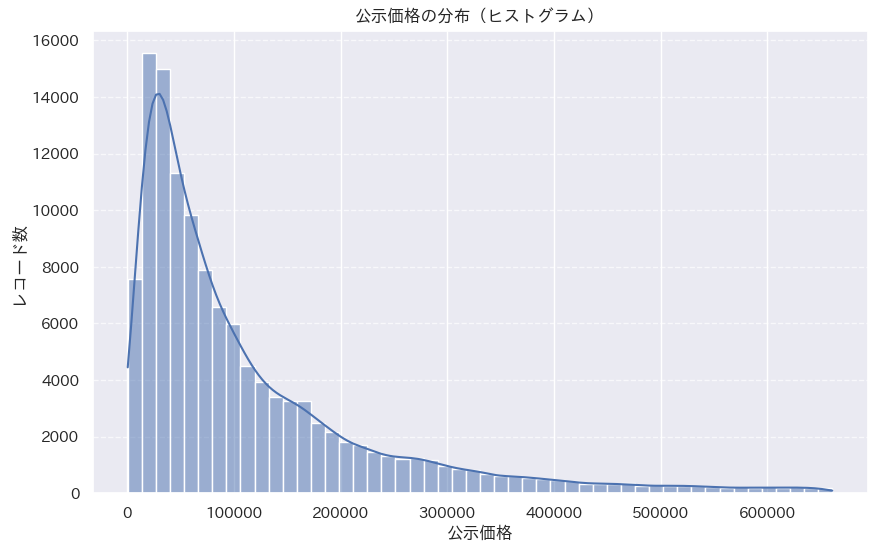

In [ ]:
# グラフを見やすくするため95%までの可視化を行う
gdf_land_values_concat['公示価格'] = pd.to_numeric(gdf_land_values_concat['公示価格'], errors='coerce')
df_land_values_plot=gdf_land_values_concat[gdf_land_values_concat['公示価格']<=661800]
plt.figure(figsize=(10,6))
sns.histplot(df_land_values_plot['公示価格'].dropna(), bins=50, kde=True)
plt.title('公示価格の分布（ヒストグラム）')
plt.xlabel('公示価格')
plt.ylabel('レコード数')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

2023年の予測価格: 76550 円
2023年の実測価格: 77900 円


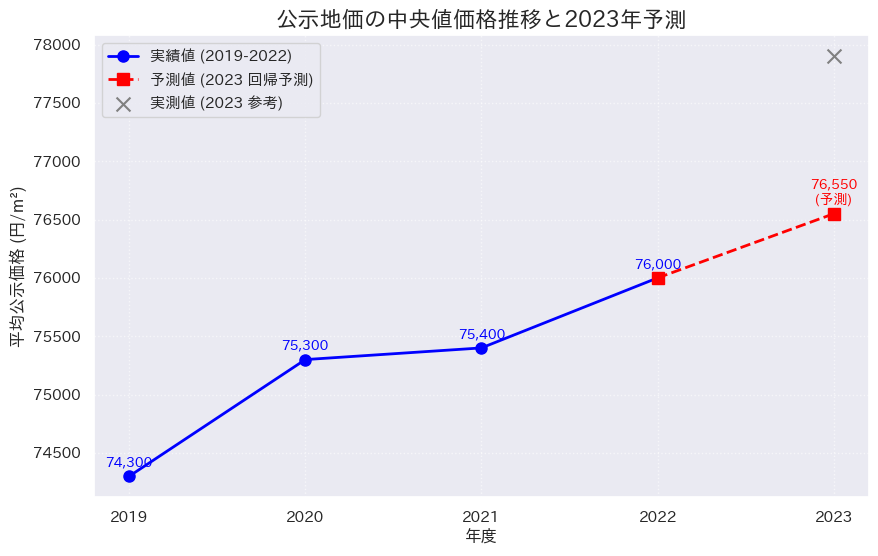

In [ ]:
# 数値型変換
gdf_all = gdf_land_values_concat.copy()
gdf_all['公示価格'] = pd.to_numeric(gdf_all['公示価格'], errors='coerce')
gdf_all['年度'] = gdf_all['年度'].astype(int)

# 平均値の算出
yearly_median = gdf_all.groupby('年度')['公示価格'].median().reset_index().sort_values('年度')

# 回帰分析 (2019-2022のデータで学習)
train_data = yearly_median[yearly_median['年度'] <= 2022]
x_train = train_data['年度']
y_train = train_data['公示価格']

coef = np.polyfit(x_train, y_train, 1)
func_predict = np.poly1d(coef)

# 2023年の予測値を計算
pred_price_2023 = func_predict(2023)

print(f"2023年の予測価格: {pred_price_2023:.0f} 円")
print(f"2023年の実測価格: {yearly_median[yearly_median['年度']==2023]['公示価格'].values[0]:.0f} 円")

# グラフ描画
plt.figure(figsize=(10, 6))

# A. 2019-2022の実績値
plt.plot(x_train, y_train, marker='o', markersize=8, linestyle='-', linewidth=2, color='blue', label='実績値 (2019-2022)')

# B. 2022(実績) -> 2023(予測) を点線で結ぶ
# 繋ぎ目を自然に見せるため、2022年の実績値から線を引きます
plt.plot([2022, 2023], [y_train.iloc[-1], pred_price_2023],
         marker='s', markersize=8, linestyle='--', linewidth=2, color='red', label='予測値 (2023 回帰予測)')

# C. (参考) 2023年の実測値（×印で表示）
# 予測がどれくらい外れたか/当たったか見るため
actual_2023 = yearly_median[yearly_median['年度'] == 2023]['公示価格'].values[0]
plt.scatter(2023, actual_2023, marker='x', s=100, color='gray', label='実測値 (2023 参考)')

# 装飾
plt.title('公示地価の中央値価格推移と2023年予測', fontsize=16)
plt.xlabel('年度', fontsize=12)
plt.ylabel('平均公示価格 (円/m²)', fontsize=12)
plt.xticks([2019, 2020, 2021, 2022, 2023])
plt.grid(True, linestyle=':', alpha=0.6)
plt.legend()

# 数値ラベルを表示
for x, y in zip(x_train, y_train):
    plt.annotate(
        f"{int(y):,}",
        xy=(x, y),
        xytext=(0, 5),
        textcoords='offset points',
        ha='center',
        va='bottom',
        fontsize=10,
        color='blue'
    )
# 予測値のラベル
plt.annotate(
    f"{int(pred_price_2023):,}\n(予測)",
    xy=(2023, pred_price_2023),
    xytext=(0, 5),
    textcoords='offset points',
    ha='center',
    va='bottom',
    fontsize=10,
    color='red',
    fontweight='bold'
)
plt.show()

In [ ]:
# 対前年変動率を年度・標準地行政区域コードごとに平均集計
# 必要なカラムの型変換
gdf_land_values_concat['対前年変動率'] = pd.to_numeric(gdf_land_values_concat['対前年変動率'], errors='coerce')
gdf_land_values_concat['年度'] = gdf_land_values_concat['年度'].astype(int)
gdf_land_values_concat['標準地行政区域コード'] = gdf_land_values_concat['標準地行政区域コード'].astype(str)

# 都道府県コード（先頭2桁）を抽出
gdf_land_values_concat['pref_code'] = gdf_land_values_concat['標準地行政区域コード'].str[:2]

# 年度・都道府県ごとに対前年変動率の平均を計算
df_mean_change = (
    gdf_land_values_concat
    .groupby(['年度', 'pref_code'])['対前年変動率']
    .mean()
    .reset_index()
    .rename(columns={'対前年変動率': 'mean_change_rate'})
)
df_mean_change=df_mean_change[df_mean_change['年度']==2022]
display(df_mean_change.head())

,年度,pref_code,mean_change_rate
141,2022,01,3.90
142,2022,02,-0.56
143,2022,03,-0.32
144,2022,04,2.63
145,2022,05,-0.72


In [ ]:
df_train_other.head()

,target_ym,money_room,building_type,building_structure,madori_kind_all,floor_count,year_built,house_area,unit_area,addr1_1,addr1_2,post1,walk_distance1,lat,lon,completion_year
0,201901,13980000,4,1.00,50,2,33,106.82,106.82,24,205,511.00,1840,35.05,136.64,199204.00
1,201901,24480000,4,10.00,50,2,44,134.04,134.04,24,205,511.00,1920,35.07,136.64,198108.00
2,201901,24480000,4,1.00,50,2,30,114.59,114.59,24,205,511.00,2000,35.07,136.64,199506.00
3,201901,16300000,4,1.00,50,2,23,106.81,106.81,23,224,478.00,480,35.00,136.88,200203.00
4,201901,18800000,1,4.00,50,6,18,76.74,76.74,23,224,478.00,320,35.00,136.88,200703.00


In [ ]:
# 特徴量追加するデータフレームの作成
df_train_feature=df_train_other.copy()
df_train_2022_feature=df_train_2022.copy()

In [ ]:
# 公示地価の前年度との比較を都道府県ごとの平均をとり追加
df_train_feature['addr1_1']=df_train_feature['addr1_1'].astype(str)
df_train_2022_feature['addr1_1']=df_train_2022_feature['addr1_1'].astype(str)
df_mean_change['pref_code']=df_mean_change['pref_code'].astype(str)

df_train_feature=pd.merge(df_train_feature,df_mean_change,left_on=['addr1_1'],right_on=['pref_code'],how='left')
df_train_2022_feature=pd.merge(df_train_2022_feature,df_mean_change,left_on=['addr1_1'],right_on=['pref_code'],how='left')
df_train_feature.drop(['年度','pref_code'],axis=1,inplace=True)
df_train_2022_feature.drop(['年度','pref_code'],axis=1,inplace=True)

### 学習

In [ ]:
#（マンション）平米単価予測 + Log + Fair Loss モデル
def train_and_predict_per_sqm_log_fair(df_train, df_test, model_name="PerSqm_LogFair"):
    df_train = df_train.copy()
    df_test = df_test.copy()

    # 平米単価の計算
    df_train['house_area'] = df_train['house_area'].astype(float)
    df_test['house_area'] = df_test['house_area'].astype(float)

    if 'price_per_sqm' not in df_train.columns:
        df_train['price_per_sqm'] = df_train['money_room'].astype(float) / df_train['house_area']
    if 'price_per_sqm' not in df_test.columns:
        df_test['price_per_sqm'] = df_test['money_room'].astype(float) / df_test['house_area']

    # 説明変数の分離(リーク防止)
    drop_cols = ['money_room', 'price_per_sqm', 'target_ym','completion_year']
    df_x_train = df_train.drop(drop_cols, axis=1, errors='ignore').copy()
    df_x_test = df_test.drop(drop_cols, axis=1, errors='ignore').copy()

    # 平米単価を対数変換
    df_y_train = np.log1p(df_train['price_per_sqm'].astype(float))
    df_y_test_log = np.log1p(df_test['price_per_sqm'].astype(float))

    # エンコード処理
    label_encoder = LabelEncoder()
    encode_cols = ['building_type', 'building_structure',
                  'addr1_1', 'addr1_2', 'post1', 'madori_kind_all']

    for col in encode_cols:
        if col in df_x_train.columns:
            all_values = pd.concat([df_x_train[col], df_x_test[col]]).astype(str)
            label_encoder.fit(all_values)
            df_x_train[col] = label_encoder.transform(df_x_train[col].astype(str))
            df_x_test[col] = label_encoder.transform(df_x_test[col].astype(str))

    # 数値変換
    for col in ['lat', 'lon', 'house_area']:
        if col in df_x_train.columns:
            df_x_train[col] = df_x_train[col].astype(float)
            df_x_test[col] = df_x_test[col].astype(float)

    # カラム整合性確保
    common_cols = [c for c in df_x_train.columns if c in df_x_test.columns]
    df_x_train = df_x_train[common_cols]
    df_x_test = df_x_test[common_cols]

    if len(df_x_train) == 0 or len(df_x_test) == 0:
        print(f"[{model_name}] データ不足のためスキップ")
        return None, None

    # LightGBMデータセット作成
    lgb_train = lgb.Dataset(df_x_train, df_y_train)
    lgb_eval = lgb.Dataset(df_x_test, df_y_test_log, reference=lgb_train)

    # Fair Lossを使用したパラメータ設定
    params = {
        'objective': 'fair',      # Fair Loss
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'num_leaves': 31,
        'fair_c': 0.1,
        'verbose': -1,
        'random_state': 42
    }

    # 学習
    model = lgb.train(
        params,
        lgb_train,
        valid_sets=[lgb_train, lgb_eval],
        valid_names=['train', 'eval'],
        num_boost_round=1000,
        callbacks=[lgb.log_evaluation(100)]
    )

    # 予測(対数空間の平米単価)
    y_pred_log_sqm = model.predict(df_x_test)

    # 対数から元の平米単価に戻す
    y_pred_sqm = np.expm1(y_pred_log_sqm)

    # 平米単価 × 面積 で総額に変換
    y_pred_total = y_pred_sqm * df_x_test['house_area']
    y_true_total = df_test['money_room'].astype(float)

    # 実金額ベースでのMAPE計算
    mape = mean_absolute_percentage_error(y_true_total, y_pred_total)
    print(f"[{model_name}] MAPE: {mape * 100:.2f}% (件数: {len(y_true_total)})")

    return y_true_total, y_pred_total


# --- （戸建・他）直接価格予測 + Log + Fair Loss モデル ---
def train_and_predict_direct_log_fair(df_train, df_test, model_name="Direct_LogFair"):
    # 説明変数の分離(リーク防止)
    drop_cols = ['money_room', 'target_ym', 'price_per_sqm','completion_year']
    df_x_train = df_train.drop(drop_cols, axis=1, errors='ignore').copy()
    df_x_test = df_test.drop(drop_cols, axis=1, errors='ignore').copy()

    # 目的変数を対数変換(Log Transformation)
    df_y_train = np.log1p(df_train['money_room'].astype(float))
    df_y_test_log = np.log1p(df_test['money_room'].astype(float))

    # エンコード処理
    label_encoder = LabelEncoder()
    encode_cols = ['building_type', 'building_structure',
                  'addr1_1', 'addr1_2', 'post1', 'madori_kind_all']

    for col in encode_cols:
        if col in df_x_train.columns:
            all_values = pd.concat([df_x_train[col], df_x_test[col]]).astype(str)
            label_encoder.fit(all_values)
            df_x_train[col] = label_encoder.transform(df_x_train[col].astype(str))
            df_x_test[col] = label_encoder.transform(df_x_test[col].astype(str))

    # 数値変換
    for col in ['lat', 'lon', 'house_area']:
        if col in df_x_train.columns:
            df_x_train[col] = df_x_train[col].astype(float)
            df_x_test[col] = df_x_test[col].astype(float)

    # カラムの整合性確保
    common_cols = [c for c in df_x_train.columns if c in df_x_test.columns]
    df_x_train = df_x_train[common_cols]
    df_x_test = df_x_test[common_cols]

    if len(df_x_train) == 0 or len(df_x_test) == 0:
        print(f"[{model_name}] データ不足のためスキップ")
        return None, None

    # LightGBMデータセット作成
    lgb_train = lgb.Dataset(df_x_train, df_y_train)
    lgb_eval = lgb.Dataset(df_x_test, df_y_test_log, reference=lgb_train)

    # Fair Lossを使用したパラメータ設定
    params = {
        'objective': 'fair',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'num_leaves': 31,
        'fair_c': 0.1,
        'verbose': -1,
        'random_state': 42
    }

    # 学習
    model = lgb.train(
        params,
        lgb_train,
        valid_sets=[lgb_train, lgb_eval],
        valid_names=['train', 'eval'],
        num_boost_round=1000,
        callbacks=[lgb.log_evaluation(100)]
    )

    # 予測(対数空間)
    y_pred_log = model.predict(df_x_test)

    # 対数から元の金額に戻す
    y_pred = np.expm1(y_pred_log)

    # 正解データ
    y_true = df_test['money_room'].astype(float)

    # 実金額ベースでのMAPE計算
    mape = mean_absolute_percentage_error(y_true, y_pred)
    print(f"[{model_name}] MAPE: {mape * 100:.2f}% (件数: {len(y_true)})")

    return y_true, y_pred

## **Tips4：経年変化率**


In [ ]:
df_light_gbm_combined = df_train_feature.copy()
df_train_2022_combined = df_train_2022_feature.copy()

# 物件種別で分割(building_type == '1' がマンション)
is_mansion_train = df_light_gbm_combined['building_type'].astype(str) == '1'
is_mansion_test = df_train_2022_combined['building_type'].astype(str) == '1'

df_train_mansion = df_light_gbm_combined[is_mansion_train].copy()
df_train_others = df_light_gbm_combined[~is_mansion_train].copy()

df_test_mansion = df_train_2022_combined[is_mansion_test].copy()
df_test_others = df_train_2022_combined[~is_mansion_test].copy()

print("\n" + "="*60)
print("平米単価(Log+Fair) × 物件種別モデル")
print("="*60)

# マンション: 平米単価 + Log + Fair Loss
print("\n=== マンション(Type=1) - 平米単価モデル(Log+Fair) ===")
y_true_m, y_pred_m = train_and_predict_per_sqm_log_fair(
    df_train_mansion,
    df_test_mansion,
    model_name="Mansion_PerSqm_LogFair"
)

# 戸建・その他: 直接予測 + Log + Fair Loss
print("\n=== 戸建・他(Type!=1) - 直接予測モデル(Log+Fair) ===")
y_true_o, y_pred_o = train_and_predict_per_sqm_log_fair(
    df_train_others,
    df_test_others,
    model_name="Others_Direct_LogFair"
)

# 結果の統合
if y_true_m is not None and y_true_o is not None:
    y_true_all = pd.concat([y_true_m, y_true_o])
    y_pred_all = np.concatenate([y_pred_m, y_pred_o])

    total_mape = mean_absolute_percentage_error(y_true_all, y_pred_all)
    print("\n" + "="*60)
    print(f"[Overall] 統合モデルの全体MAPE: {total_mape * 100:.2f}%")
    print(f"  - マンション件数: {len(y_true_m)}")
    print(f"  - 戸建・他件数: {len(y_true_o)}")
    print(f"  - 合計件数: {len(y_true_all)}")
    print("="*60)
else:
    print("\n[警告] いずれかのモデルでデータ不足のため統合できませんでした")


平米単価(Log+Fair) × 物件種別モデル

=== マンション(Type=1) - 平米単価モデル(Log+Fair) ===
[100]	train's rmse: 0.230897	eval's rmse: 0.264167
[200]	train's rmse: 0.214922	eval's rmse: 0.253756
[300]	train's rmse: 0.205676	eval's rmse: 0.248194
[400]	train's rmse: 0.198551	eval's rmse: 0.244128
[500]	train's rmse: 0.192896	eval's rmse: 0.241339
[600]	train's rmse: 0.188643	eval's rmse: 0.239418
[700]	train's rmse: 0.184967	eval's rmse: 0.238084
[800]	train's rmse: 0.181523	eval's rmse: 0.236701
[900]	train's rmse: 0.178577	eval's rmse: 0.235774
[1000]	train's rmse: 0.175908	eval's rmse: 0.234919
[Mansion_PerSqm_LogFair] MAPE: 17.25% (件数: 47034)

=== 戸建・他(Type!=1) - 直接予測モデル(Log+Fair) ===
[100]	train's rmse: 0.324157	eval's rmse: 0.352046
[200]	train's rmse: 0.306788	eval's rmse: 0.342712
[300]	train's rmse: 0.296112	eval's rmse: 0.337379
[400]	train's rmse: 0.287045	eval's rmse: 0.333713
[500]	train's rmse: 0.279592	eval's rmse: 0.330929
[600]	train's rmse: 0.273498	eval's rmse: 0.329136
[700]	train's rmse: 0

# 建物について

### 新耐震 vs 旧耐震

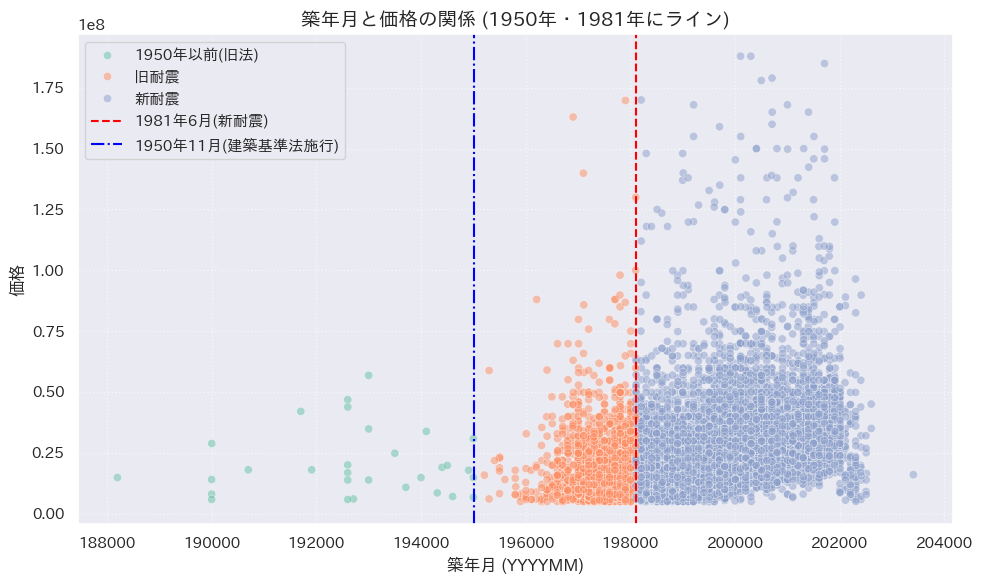

In [ ]:
#新耐震と旧耐震についての可視化を行う
# 1. データの準備
df = df_train_raw.copy()
price_col = 'money_room'

# 2. 前処理
df = df.dropna(subset=['year_built', price_col])
df['year_built'] = df['year_built'].astype(int)

# 3. 耐震基準等のフラグ作成
cutoff_new = 198106
cutoff_1950 = 195011

def categorize_seismic(year_month):
    if year_month >= cutoff_new:
        return '新耐震'
    elif year_month >= cutoff_1950:
        return '旧耐震'
    else:
        return '1950年以前(旧法)'

df['耐震基準'] = df['year_built'].apply(categorize_seismic)
order_list = ['1950年以前(旧法)', '旧耐震', '新耐震']

# --- 【補完】描画用にデータを間引く（全件だと重いため） ---
# データ件数が多すぎる場合はここで調整してください
sample_df = df.sample(n=min(len(df), 10000), random_state=42)

# 4. 可視化（1つのグラフとして描画）
plt.figure(figsize=(10, 6))
ax = plt.gca() # 現在の描画エリアを取得

# 散布図の描画
sns.scatterplot(
    x='year_built',
    y=price_col,
    data=sample_df,
    hue='耐震基準',
    hue_order=order_list,
    alpha=0.5,
    ax=ax,
    palette='Set2'
)

# 垂直線の追加
ax.axvline(x=cutoff_new, color='red', linestyle='--', label='1981年6月(新耐震)')
ax.axvline(x=cutoff_1950, color='blue', linestyle='-.', label='1950年11月(建築基準法施行)')

# ラベル等の設定
ax.set_title('築年月と価格の関係 (1950年・1981年にライン)', fontsize=14)
ax.set_xlabel('築年月 (YYYYMM)', fontsize=12)
ax.set_ylabel('価格', fontsize=12)
ax.legend()
ax.grid(True, linestyle=':', alpha=0.6)

plt.tight_layout()
plt.show()

/tmp/ipython-input-916736188.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


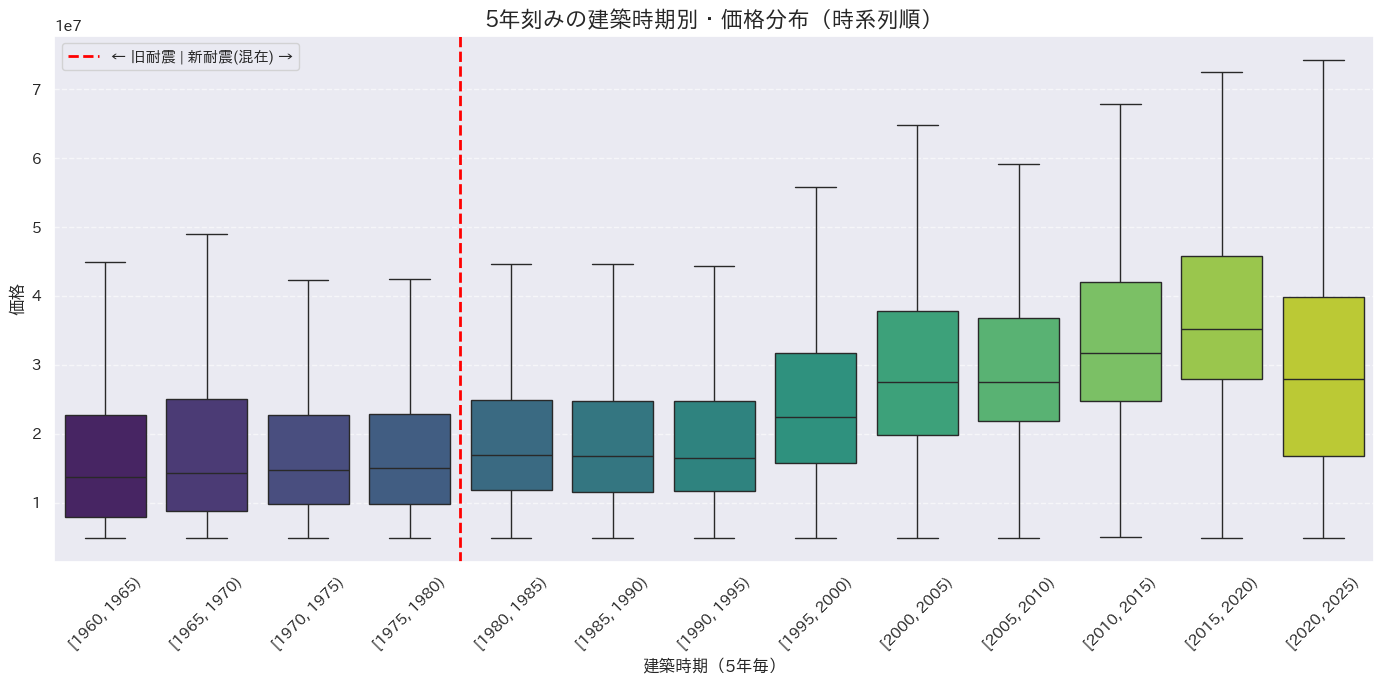

In [ ]:
# データの準備
df = df_train_raw.copy()
price_col = 'money_room'

# 前処理
df = df.dropna(subset=['year_built', price_col])
df['year_built'] = df['year_built'].astype(int)
df['build_year'] = df['year_built'] // 100
df = df[(df['build_year'] >= 1960) & (df['build_year'] <= 2023)]

# --- 5年刻みのビン（区切り）を作る ---
# right=False にすると [1960, 1965) となり「1960以上1965未満」という扱いやすくなります
bins = range(1960, 2030, 5)
df['build_period'] = pd.cut(df['build_year'], bins=bins, right=False)

# --- 【修正点】並び順を保証するための処理 ---
# 1. 文字列に変換
df['build_period_str'] = df['build_period'].astype(str)

# 2. 正しい順序のリストを作成（Interval型としてソートしてから文字列にする）
# これをしないと文字列の "19..." の順序でバラバラになる可能性があります
period_order = sorted(df['build_period'].dropna().unique())
period_order_str = [str(p) for p in period_order]

# 可視化
plt.figure(figsize=(14, 7)) # 横幅を少し広げました

# --- order引数にソート済みのリストを渡します ---
sns.boxplot(
    x='build_period_str',
    y=price_col,
    data=df,
    palette='viridis',
    showfliers=False,
    order=period_order_str  # <--- ここで並び順を固定
)

plt.axvline(x=3.5, color='red', linestyle='--', linewidth=2, label='← 旧耐震 | 新耐震(混在) →')

plt.title('5年刻みの建築時期別・価格分布（時系列順）', fontsize=16)
plt.xlabel('建築時期（5年毎）', fontsize=12)
plt.ylabel('価格', fontsize=12)
plt.xticks(rotation=45) # ラベルが重ならないよう斜めにする
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

## Tips5：新耐震,旧耐震_flagの付与

In [ ]:
# 特徴量をつけるためのデータフレームの作成
df_train_feature_bldg=df_train_feature.copy()
df_train_2022_feature_bldg=df_train_2022_feature.copy()

In [ ]:
df_train_feature_bldg.head()

,target_ym,money_room,building_type,building_structure,madori_kind_all,floor_count,year_built,house_area,unit_area,addr1_1,addr1_2,post1,walk_distance1,lat,lon,completion_year,mean_change_rate
0,201901,13980000,4,1.00,50,2,33,106.82,106.82,24,205,511.00,1840,35.05,136.64,199204.00,-0.67
1,201901,24480000,4,10.00,50,2,44,134.04,134.04,24,205,511.00,1920,35.07,136.64,198108.00,-0.67
2,201901,24480000,4,1.00,50,2,30,114.59,114.59,24,205,511.00,2000,35.07,136.64,199506.00,-0.67
3,201901,16300000,4,1.00,50,2,23,106.81,106.81,23,224,478.00,480,35.00,136.88,200203.00,1.19
4,201901,18800000,1,4.00,50,6,18,76.74,76.74,23,224,478.00,320,35.00,136.88,200703.00,1.19


In [ ]:
# 新耐震、旧耐震、旧耐震以前を判別する関数の作成
def classify_seismic(year):
    if year >= 198106: # 正確には1981年6月以降
        return 2  # 新耐震
    elif year >= 195012:
        return 1  # 旧耐震（旧耐震）
    else:
        return 0  # 旧旧耐震（それ以前）

In [ ]:
# flagを付与する
df_train_feature_bldg['completion_year'] = pd.to_numeric(df_train_feature_bldg['completion_year'], errors='coerce')
# 欠損値を中央値で補完し、float型に変換
median_year = df_train_feature_bldg['completion_year'].median()
df_train_feature_bldg['completion_year'] = df_train_feature_bldg['completion_year'].fillna(median_year).astype(float)
df_train_feature_bldg['seismic_type']=df_train_feature_bldg['completion_year'].apply(classify_seismic)

df_train_2022_feature_bldg['completion_year'] = pd.to_numeric(df_train_2022_feature_bldg['completion_year'], errors='coerce')
# 欠損値を中央値で補完し、float型に変換
median_year = df_train_2022_feature_bldg['completion_year'].median()
df_train_2022_feature_bldg['completion_year'] = df_train_2022_feature_bldg['completion_year'].fillna(median_year).astype(float)
df_train_2022_feature_bldg['seismic_type']=df_train_2022_feature_bldg['completion_year'].apply(classify_seismic)

df_train_feature_bldg[['completion_year','seismic_type']].head()

,completion_year,seismic_type
0,199204.00,2
1,198108.00,2
2,199506.00,2
3,200203.00,2
4,200703.00,2


## 学習

In [ ]:
#平米単価予測 + Log + Fair Loss モデル
def train_and_predict_per_sqm_log_fair(df_train, df_test, model_name="PerSqm_LogFair"):
    df_train = df_train.copy()
    df_test = df_test.copy()

    # 平米単価の計算
    df_train['house_area'] = df_train['house_area'].astype(float)
    df_test['house_area'] = df_test['house_area'].astype(float)

    if 'price_per_sqm' not in df_train.columns:
        df_train['price_per_sqm'] = df_train['money_room'].astype(float) / df_train['house_area']
    if 'price_per_sqm' not in df_test.columns:
        df_test['price_per_sqm'] = df_test['money_room'].astype(float) / df_test['house_area']

    # 説明変数の分離
    drop_cols = ['money_room', 'price_per_sqm', 'target_ym','completion_year']
    df_x_train = df_train.drop(drop_cols, axis=1, errors='ignore').copy()
    df_x_test = df_test.drop(drop_cols, axis=1, errors='ignore').copy()

    #平米単価を対数変換
    df_y_train = np.log1p(df_train['price_per_sqm'].astype(float))
    df_y_test_log = np.log1p(df_test['price_per_sqm'].astype(float))

    # エンコード処理
    label_encoder = LabelEncoder()
    encode_cols = ['building_type', 'building_structure',
                  'addr1_1', 'addr1_2', 'post1', 'madori_kind_all','seismic_type']

    for col in encode_cols:
        if col in df_x_train.columns:
            all_values = pd.concat([df_x_train[col], df_x_test[col]]).astype(str)
            label_encoder.fit(all_values)
            df_x_train[col] = label_encoder.transform(df_x_train[col].astype(str))
            df_x_test[col] = label_encoder.transform(df_x_test[col].astype(str))

    # 数値変換
    for col in ['lat', 'lon', 'house_area']:
        if col in df_x_train.columns:
            df_x_train[col] = df_x_train[col].astype(float)
            df_x_test[col] = df_x_test[col].astype(float)

    # カラム整合性確保
    common_cols = [c for c in df_x_train.columns if c in df_x_test.columns]
    df_x_train = df_x_train[common_cols]
    df_x_test = df_x_test[common_cols]

    if len(df_x_train) == 0 or len(df_x_test) == 0:
        print(f"[{model_name}] データ不足のためスキップ")
        return None, None

    # LightGBMデータセット作成
    lgb_train = lgb.Dataset(df_x_train, df_y_train)
    lgb_eval = lgb.Dataset(df_x_test, df_y_test_log, reference=lgb_train)

    # Fair Lossを使用したパラメータ設定
    params = {
        'objective': 'fair',      # Fair Loss
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'num_leaves': 31,
        'fair_c': 0.1,
        'verbose': -1,
        'random_state': 42
    }

    # 学習
    model = lgb.train(
        params,
        lgb_train,
        valid_sets=[lgb_train, lgb_eval],
        valid_names=['train', 'eval'],
        num_boost_round=1000,
        callbacks=[lgb.log_evaluation(100)]
    )

    # 予測(対数空間の平米単価)
    y_pred_log_sqm = model.predict(df_x_test)

    # 対数から元の平米単価に戻す
    y_pred_sqm = np.expm1(y_pred_log_sqm)

    # 平米単価 × 面積 で総額に変換
    y_pred_total = y_pred_sqm * df_x_test['house_area']
    y_true_total = df_test['money_room'].astype(float)

    # 実金額ベースでのMAPE計算
    mape = mean_absolute_percentage_error(y_true_total, y_pred_total)
    print(f"[{model_name}] MAPE: {mape * 100:.2f}% (件数: {len(y_true_total)})")

    return y_true_total, y_pred_total


def train_and_predict_direct_log_fair(df_train, df_test, model_name="Direct_LogFair"):
    # 説明変数の分離
    drop_cols = ['money_room', 'target_ym', 'price_per_sqm']
    df_x_train = df_train.drop(drop_cols, axis=1, errors='ignore').copy()
    df_x_test = df_test.drop(drop_cols, axis=1, errors='ignore').copy()

    # 目的変数を対数変換
    df_y_train = np.log1p(df_train['money_room'].astype(float))
    df_y_test_log = np.log1p(df_test['money_room'].astype(float))

    # エンコード処理
    label_encoder = LabelEncoder()
    encode_cols = ['building_type', 'building_structure',
                  'addr1_1', 'addr1_2', 'post1', 'madori_kind_all','completion_year']

    for col in encode_cols:
        if col in df_x_train.columns:
            all_values = pd.concat([df_x_train[col], df_x_test[col]]).astype(str)
            label_encoder.fit(all_values)
            df_x_train[col] = label_encoder.transform(df_x_train[col].astype(str))
            df_x_test[col] = label_encoder.transform(df_x_test[col].astype(str))

    # 数値変換
    for col in ['lat', 'lon', 'house_area']:
        if col in df_x_train.columns:
            df_x_train[col] = df_x_train[col].astype(float)
            df_x_test[col] = df_x_test[col].astype(float)

    # カラムの整合性確保
    common_cols = [c for c in df_x_train.columns if c in df_x_test.columns]
    df_x_train = df_x_train[common_cols]
    df_x_test = df_x_test[common_cols]

    if len(df_x_train) == 0 or len(df_x_test) == 0:
        print(f"[{model_name}] データ不足のためスキップ")
        return None, None

    # LightGBMデータセット作成
    lgb_train = lgb.Dataset(df_x_train, df_y_train)
    lgb_eval = lgb.Dataset(df_x_test, df_y_test_log, reference=lgb_train)

    # Fair Lossを使用したパラメータ設定
    params = {
        'objective': 'fair',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'num_leaves': 31,
        'fair_c': 0.1,
        'verbose': -1,
        'random_state': 42
    }

    # 学習
    model = lgb.train(
        params,
        lgb_train,
        valid_sets=[lgb_train, lgb_eval],
        valid_names=['train', 'eval'],
        num_boost_round=1000,
        callbacks=[lgb.log_evaluation(100)]
    )

    # 予測
    y_pred_log = model.predict(df_x_test)

    # 対数から元の金額に戻す
    y_pred = np.expm1(y_pred_log)

    # 正解データ
    y_true = df_test['money_room'].astype(float)

    # 実金額ベースでのMAPE計算
    mape = mean_absolute_percentage_error(y_true, y_pred)
    print(f"[{model_name}] MAPE: {mape * 100:.2f}% (件数: {len(y_true)})")

    return y_true, y_pred

In [ ]:
# データ準備
df_light_gbm_combined = df_train_feature_bldg.copy()
df_train_2022_combined = df_train_2022_feature_bldg.copy()

# 物件種別で分割(building_type == '1' がマンション)
is_mansion_train = df_light_gbm_combined['building_type'].astype(str) == '1'
is_mansion_test = df_train_2022_combined['building_type'].astype(str) == '1'

df_train_mansion = df_light_gbm_combined[is_mansion_train].copy()
df_train_others = df_light_gbm_combined[~is_mansion_train].copy()

df_test_mansion = df_train_2022_combined[is_mansion_test].copy()
df_test_others = df_train_2022_combined[~is_mansion_test].copy()

print("\n" + "="*60)
print("平米単価(Log+Fair) × 物件種別モデル")
print("="*60)

# マンション: 平米単価 + Log + Fair Loss
print("\n=== マンション(Type=1) - 平米単価モデル(Log+Fair) ===")
y_true_m, y_pred_m = train_and_predict_per_sqm_log_fair(
    df_train_mansion,
    df_test_mansion,
    model_name="Mansion_PerSqm_LogFair"
)

# 戸建・その他: 直接予測 + Log + Fair Loss
print("\n=== 戸建・他(Type!=1) - 直接予測モデル(Log+Fair) ===")
y_true_o, y_pred_o = train_and_predict_direct_log_fair(
    df_train_others,
    df_test_others,
    model_name="Others_Direct_LogFair"
)

# 結果の統合
if y_true_m is not None and y_true_o is not None:
    y_true_all = pd.concat([y_true_m, y_true_o])
    y_pred_all = np.concatenate([y_pred_m, y_pred_o])

    total_mape = mean_absolute_percentage_error(y_true_all, y_pred_all)
    print("\n" + "="*60)
    print(f"[Overall] 統合モデルの全体MAPE: {total_mape * 100:.2f}%")
    print(f"  - マンション件数: {len(y_true_m)}")
    print(f"  - 戸建・他件数: {len(y_true_o)}")
    print(f"  - 合計件数: {len(y_true_all)}")
    print("="*60)
else:
    print("\n[警告] いずれかのモデルでデータ不足のため統合できませんでした")


平米単価(Log+Fair) × 物件種別モデル

=== マンション(Type=1) - 平米単価モデル(Log+Fair) ===
[100]	train's rmse: 0.231589	eval's rmse: 0.264504
[200]	train's rmse: 0.215673	eval's rmse: 0.254009
[300]	train's rmse: 0.20561	eval's rmse: 0.24798
[400]	train's rmse: 0.198902	eval's rmse: 0.244434
[500]	train's rmse: 0.193489	eval's rmse: 0.241891
[600]	train's rmse: 0.189064	eval's rmse: 0.24
[700]	train's rmse: 0.185261	eval's rmse: 0.238471
[800]	train's rmse: 0.182093	eval's rmse: 0.237266
[900]	train's rmse: 0.178994	eval's rmse: 0.236362
[1000]	train's rmse: 0.175971	eval's rmse: 0.235184
[Mansion_PerSqm_LogFair] MAPE: 17.32% (件数: 47034)

=== 戸建・他(Type!=1) - 直接予測モデル(Log+Fair) ===
[100]	train's rmse: 0.328678	eval's rmse: 0.364736
[200]	train's rmse: 0.308959	eval's rmse: 0.354093
[300]	train's rmse: 0.296704	eval's rmse: 0.347854
[400]	train's rmse: 0.28753	eval's rmse: 0.343683
[500]	train's rmse: 0.279716	eval's rmse: 0.340813
[600]	train's rmse: 0.273095	eval's rmse: 0.338121
[700]	train's rmse: 0.267512

# 立地について

### 同じようなマンションに対して都道府県ごと平米単価の比較

【比較条件（最頻条件）】
・間取り　: 50
・階数　　: 2階
・築年数　: 35年 (前後2年を許容範囲とします)
抽出データ件数: 11041件


/tmp/ipython-input-574228372.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


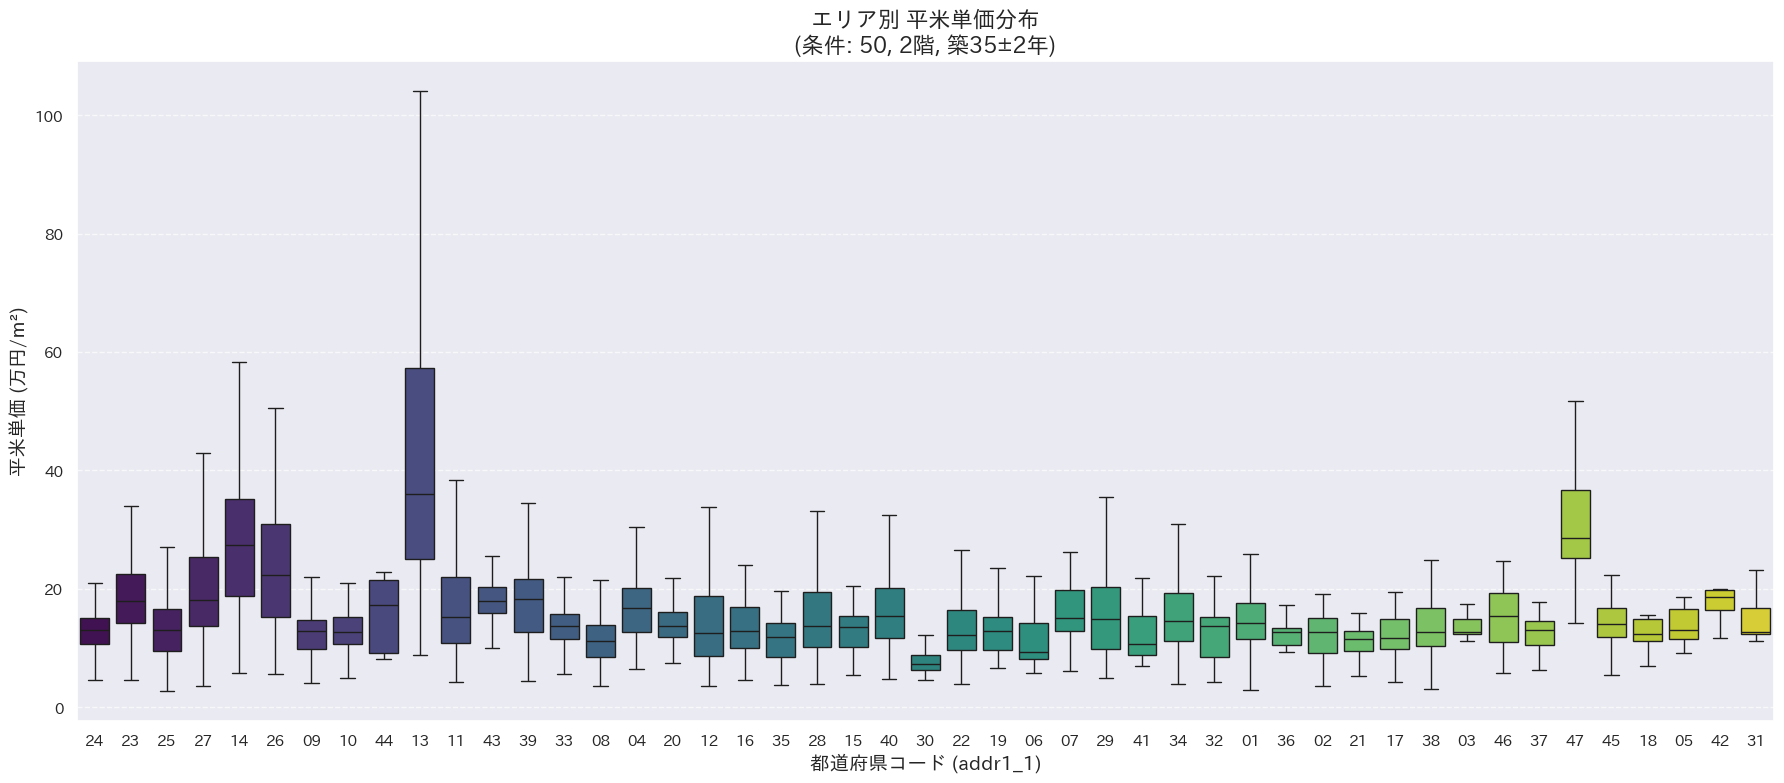

In [ ]:
# 分析用にデータをコピー
df_viz = df_train.copy()

# 平米単価（万円/m²）を算出
# ※ money_roomは円単位、house_areaはm²単位と想定
df_viz['unit_price_man'] = (df_viz['money_room'] / df_viz['house_area']) / 10000

target_madori=50
target_floor=2
target_year=35

print(f"【比較条件（最頻条件）】")
print(f"・間取り　: {target_madori}")
print(f"・階数　　: {target_floor}階")
print(f"・築年数　: {int(target_year)}年 (前後2年を許容範囲とします)")

#  データの抽出 ---
# 条件に合致するデータのみを抽出（築年数は±2年の幅を持たせる）
mask_cond = (
    (df_viz['madori_kind_all'] == target_madori) &
    (df_viz['floor_count'] == target_floor) &
    (df_viz['year_built'] >= target_year - 2) &
    (df_viz['year_built'] <= target_year + 2)
)
df_filtered = df_viz[mask_cond].copy()

print(f"抽出データ件数: {len(df_filtered)}件")

#可視化(箱ひげ図)
plt.figure(figsize=(18, 8))

# 箱ひげ図の描画
# x軸: addr1_1 (都道府県コード), y軸: unit_price_man (平米単価)
sns.boxplot(
    data=df_filtered,
    x='addr1_1',
    y='unit_price_man',
    palette='viridis',
    showfliers=False
)

plt.title(f'エリア別 平米単価分布\n(条件: {target_madori}, {target_floor}階, 築{int(target_year)}±2年)', fontsize=16)
plt.xlabel('都道府県コード (addr1_1)', fontsize=14)
plt.ylabel('平米単価 (万円/m²)', fontsize=14)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# 都道府県コードの意味（例：13=東京）がわかるようにラベルを回転
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

### 地価公示の付与

### 地価のエリア別詳細（交互作用）

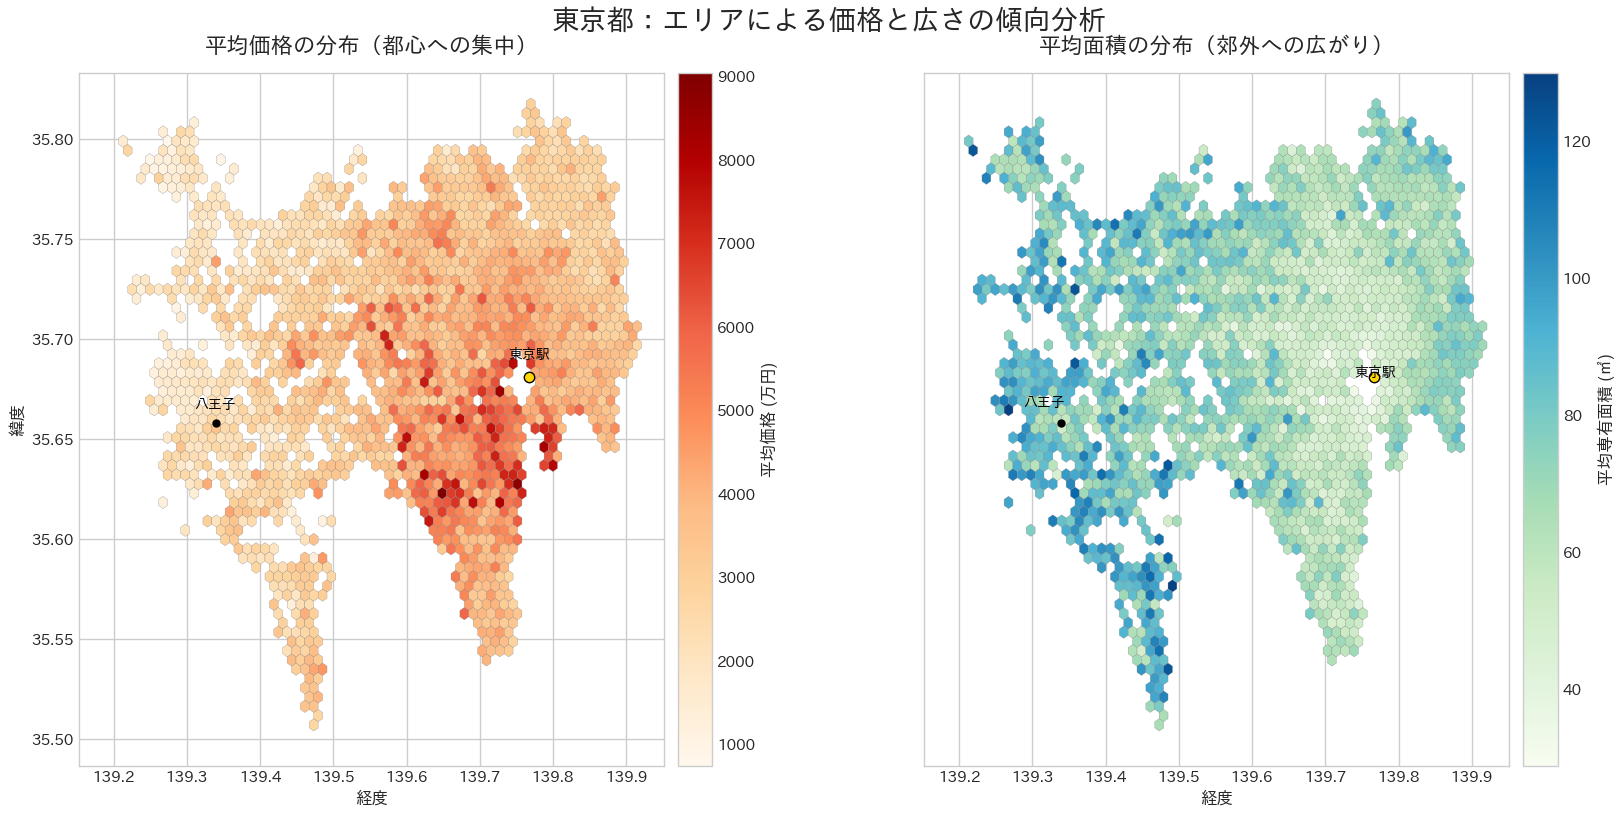

In [ ]:
warnings.filterwarnings('ignore', category=UserWarning)
plt.style.use('seaborn-v0_8-whitegrid')
japanize_matplotlib.japanize()

df = df_train_raw.copy()

# 東京都のみ抽出
df_tokyo = df[df['full_address'].str.contains('東京都', na=False)].copy()

# 変数作成
df_tokyo['price_man'] = df_tokyo['money_room'] / 10000  # 万円
df_tokyo['house_area'] = df_tokyo['house_area']         # m2

# 外れ値除去
p_cap = df_tokyo['price_man'].quantile(0.98)
a_cap = df_tokyo['house_area'].quantile(0.98)

df_viz = df_tokyo[
    (df_tokyo['price_man'] < p_cap) &
    (df_tokyo['house_area'] < a_cap)
]

#可視化
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 9))

gridsize = 60
mincnt = 5

# === 左図：価格 ===
hb1 = ax1.hexbin(
    df_viz['lon'], df_viz['lat'],
    C=df_viz['price_man'],
    gridsize=gridsize,
    cmap='OrRd',
    reduce_C_function=np.mean,
    mincnt=mincnt,
    linewidths=0.2, edgecolors='gray'
)
ax1.set_title('平均価格の分布（都心への集中）', fontsize=16, pad=15)
ax1.set_xlabel('経度', fontsize=12)
ax1.set_ylabel('緯度', fontsize=12)

# マーカー
ax1.plot(139.767, 35.681, marker='.', color='gold', markersize=15, markeredgecolor='black')
ax1.text(139.767, 35.69, '東京駅', color='black', ha='center', fontsize=10, fontweight='bold')
ax1.plot(139.339, 35.658, marker='.', color='black', markersize=10)
ax1.text(139.339, 35.665, '八王子', color='black', ha='center', fontsize=10)

cb1 = fig.colorbar(hb1, ax=ax1, pad=0.02)
cb1.set_label('平均価格 (万円)', fontsize=12)

# === 右図：面積 ===
hb2 = ax2.hexbin(
    df_viz['lon'], df_viz['lat'],
    C=df_viz['house_area'],
    gridsize=gridsize,
    cmap='GnBu',
    reduce_C_function=np.mean,
    mincnt=mincnt,
    linewidths=0.2, edgecolors='gray'
)
ax2.set_title('平均面積の分布（郊外への広がり）', fontsize=16, pad=15)
ax2.set_xlabel('経度', fontsize=12)
ax2.set_yticks([])

# マーカー
ax2.plot(139.767, 35.681, marker='.', color='gold', markersize=15, markeredgecolor='black')
ax2.text(139.7673, 35.6809, '東京駅', color='black', ha='center', fontsize=10, fontweight='bold')
ax2.plot(139.339, 35.658, marker='.', color='black', markersize=10)
ax2.text(139.3158, 35.6663, '八王子', color='black', ha='center', fontsize=10)

cb2 = fig.colorbar(hb2, ax=ax2, pad=0.02)
cb2.set_label('平均専有面積 (㎡)', fontsize=12)

plt.suptitle('東京都：エリアによる価格と広さの傾向分析', fontsize=20, y=0.95)

plt.show()

In [ ]:
gdf_land_values_concat.head()

,見出し番号,一連番号,昨年見出し番号,昨年一連番号,年度,公示価格,標準地行政区域コード,geometry,対前年変動率,pref_code
0,000,001,000,001,2019,340000,01101,POINT (141.31405 43.05545),NaN,01
1,000,002,000,002,2019,139000,01101,POINT (141.3394 43.04181),NaN,01
2,000,003,000,003,2019,131000,01101,POINT (141.34456 43.04713),NaN,01
3,000,004,000,004,2019,144000,01101,POINT (141.34944 43.03639),NaN,01
4,000,005,000,005,2019,49400,01101,POINT (141.3153 43.0439),NaN,01


In [ ]:
# 対前年変動率を年度・都道府県ごとに中央値集計
gdf_land_values_concat['pref_code'] = gdf_land_values_concat['標準地行政区域コード'].str[:2]
gdf_land_values_concat['公示価格']=gdf_land_values_concat['公示価格'].astype(float)
# 年度・都道府県ごとに対前年変動率の中央値を計算
df_median_land_price = (
    gdf_land_values_concat
    .groupby(['年度', 'pref_code'])['公示価格']
    .median()
    .reset_index()
    .rename(columns={'公示価格': 'median_land_price'})
)
display(df_median_land_price.head())

,年度,pref_code,median_land_price
0,2019,01,26000.00
1,2019,02,24100.00
2,2019,03,31600.00
3,2019,04,54500.00
4,2019,05,20200.00


In [ ]:
df_train_2022_feature.head()

,target_ym,money_room,building_type,building_structure,madori_kind_all,floor_count,year_built,house_area,unit_area,addr1_1,addr1_2,post1,walk_distance1,lat,lon,completion_year,mean_change_rate
0,202201,16900000,1,5.00,55,14,32,76.20,76.20,24,205,511.00,720,35.07,136.69,199306.00,-0.67
1,202201,16000000,1,4.00,50,11,21,95.96,95.96,24,205,511.00,480,35.06,136.68,200412.00,-0.67
2,202201,17800000,4,1.00,30,1,27,79.49,79.49,24,205,511.00,1040,35.06,136.69,199806.00,-0.67
3,202201,18990000,4,1.00,55,1,28,117.83,117.83,24,205,511.00,2720,35.05,136.62,199712.00,-0.67
4,202201,13990000,4,1.00,50,2,29,114.74,114.74,24,205,511.00,2240,35.05,136.63,199604.00,-0.67


In [ ]:
df_train_feature_land_price=df_train_feature_bldg.copy()
df_train_2022_feature_land_price=df_train_2022_feature_bldg.copy()

In [ ]:
#　公示地価の前年度との比較を都道府県ごとの平均をとり追加
df_train_feature_land_price['year']=df_train_feature_land_price['target_ym'].astype(str).str[:4].astype(int)
df_train_2022_feature_land_price['year']=df_train_2022_feature_land_price['target_ym'].astype(str).str[:4].astype(int)
df_median_land_price['年度']=df_median_land_price['年度'].astype(int)
df_train_feature_land_price=pd.merge(df_train_feature_land_price,df_median_land_price,left_on=['year','addr1_1'],right_on=['年度','pref_code'],how='left')
df_train_2022_feature_land_price=pd.merge(df_train_2022_feature_land_price,df_median_land_price,left_on=['year','addr1_1'],right_on=['年度','pref_code'],how='left')
df_train_feature_land_price.drop(['年度','pref_code'],axis=1,inplace=True)
df_train_2022_feature_land_price.drop(['年度','pref_code'],axis=1,inplace=True)
df_train_feature_land_price.head()

,target_ym,money_room,building_type,building_structure,madori_kind_all,floor_count,year_built,house_area,unit_area,addr1_1,addr1_2,post1,walk_distance1,lat,lon,completion_year,mean_change_rate,seismic_type,year,median_land_price
0,201901,13980000,4,1.00,50,2,33,106.82,106.82,24,205,511.00,1840,35.05,136.64,199204.00,-0.67,2,2019,41250.00
1,201901,24480000,4,10.00,50,2,44,134.04,134.04,24,205,511.00,1920,35.07,136.64,198108.00,-0.67,2,2019,41250.00
2,201901,24480000,4,1.00,50,2,30,114.59,114.59,24,205,511.00,2000,35.07,136.64,199506.00,-0.67,2,2019,41250.00
3,201901,16300000,4,1.00,50,2,23,106.81,106.81,23,224,478.00,480,35.00,136.88,200203.00,1.19,2,2019,104000.00
4,201901,18800000,1,4.00,50,6,18,76.74,76.74,23,224,478.00,320,35.00,136.88,200703.00,1.19,2,2019,104000.00


#### 学習

In [ ]:
# データ準備
df_light_gbm_combined_land_price = df_train_feature_land_price.copy()
df_train_2022_combined_land_price = df_train_2022_feature_land_price.copy()

# 物件種別で分割(building_type == '1' がマンション)
is_mansion_train = df_light_gbm_combined_land_price['building_type'].astype(str) == '1'
is_mansion_test = df_train_2022_combined_land_price['building_type'].astype(str) == '1'

df_train_mansion = df_light_gbm_combined_land_price[is_mansion_train].copy()
df_train_others = df_light_gbm_combined_land_price[~is_mansion_train].copy()

df_test_mansion = df_train_2022_combined_land_price[is_mansion_test].copy()
df_test_others = df_train_2022_combined_land_price[~is_mansion_test].copy()

print("\n" + "="*60)
print("平米単価(Log+Fair) × 物件種別モデル")
print("="*60)

# マンション: 平米単価 + Log + Fair Loss
print("\n=== マンション(Type=1) - 平米単価モデル(Log+Fair) ===")
y_true_m, y_pred_m = train_and_predict_per_sqm_log_fair(
    df_train_mansion,
    df_test_mansion,
    model_name="Mansion_PerSqm_LogFair"
)

# 戸建・その他: 直接予測 + Log + Fair Loss
print("\n=== 戸建・他(Type!=1) - 直接予測モデル(Log+Fair) ===")
y_true_o, y_pred_o = train_and_predict_direct_log_fair(
    df_train_others,
    df_test_others,
    model_name="Others_Direct_LogFair"
)

# 結果の統合
if y_true_m is not None and y_true_o is not None:
    y_true_all = pd.concat([y_true_m, y_true_o])
    y_pred_all = np.concatenate([y_pred_m, y_pred_o])

    total_mape = mean_absolute_percentage_error(y_true_all, y_pred_all)
    print("\n" + "="*60)
    print(f"[Overall] 統合モデルの全体MAPE: {total_mape * 100:.2f}%")
    print(f"  - マンション件数: {len(y_true_m)}")
    print(f"  - 戸建・他件数: {len(y_true_o)}")
    print(f"  - 合計件数: {len(y_true_all)}")
    print("="*60)
else:
    print("\n[警告] いずれかのモデルでデータ不足のため統合できませんでした")


平米単価(Log+Fair) × 物件種別モデル

=== マンション(Type=1) - 平米単価モデル(Log+Fair) ===
[100]	train's rmse: 0.23234	eval's rmse: 0.256824
[200]	train's rmse: 0.214981	eval's rmse: 0.243459
[300]	train's rmse: 0.205067	eval's rmse: 0.236849
[400]	train's rmse: 0.198408	eval's rmse: 0.232937
[500]	train's rmse: 0.192764	eval's rmse: 0.229944
[600]	train's rmse: 0.188265	eval's rmse: 0.227586
[700]	train's rmse: 0.18435	eval's rmse: 0.225856
[800]	train's rmse: 0.180855	eval's rmse: 0.224259
[900]	train's rmse: 0.177891	eval's rmse: 0.223066
[1000]	train's rmse: 0.175337	eval's rmse: 0.222212
[Mansion_PerSqm_LogFair] MAPE: 16.46% (件数: 47034)

=== 戸建・他(Type!=1) - 直接予測モデル(Log+Fair) ===
[100]	train's rmse: 0.329573	eval's rmse: 0.360565
[200]	train's rmse: 0.30927	eval's rmse: 0.349306
[300]	train's rmse: 0.296967	eval's rmse: 0.343245
[400]	train's rmse: 0.287862	eval's rmse: 0.339874
[500]	train's rmse: 0.280094	eval's rmse: 0.337113
[600]	train's rmse: 0.273762	eval's rmse: 0.335052
[700]	train's rmse: 0.26

## エリア別モデル

### Tips6：一都三県とそれ以外に分割

In [ ]:
# 一都三県の都道府県コード
tokyo_area_codes = ['13', '14', '11', '12']  # 東京都, 神奈川県, 埼玉県, 千葉県

# 一都三県・それ以外で分割
is_tokyo_area_train = df_light_gbm_combined_land_price['addr1_1'].astype(str).isin(tokyo_area_codes)
is_tokyo_area_test = df_train_2022_combined_land_price['addr1_1'].astype(str).isin(tokyo_area_codes)

# 一都三県
df_train_tokyo = df_light_gbm_combined_land_price[is_tokyo_area_train].copy()
df_test_tokyo = df_train_2022_combined_land_price[is_tokyo_area_test].copy()

# それ以外
df_train_other = df_light_gbm_combined_land_price[~is_tokyo_area_train].copy()
df_test_other = df_train_2022_combined_land_price[~is_tokyo_area_test].copy()

# 物件種別で分割
def split_by_type(df):
    is_mansion = df['building_type'].astype(str) == '1'
    return df[is_mansion].copy(), df[~is_mansion].copy()

# 一都三県
df_train_tokyo_mansion, df_train_tokyo_others = split_by_type(df_train_tokyo)
df_test_tokyo_mansion, df_test_tokyo_others = split_by_type(df_test_tokyo)

# それ以外
df_train_other_mansion, df_train_other_others = split_by_type(df_train_other)
df_test_other_mansion, df_test_other_others = split_by_type(df_test_other)

# 全体統合用のリスト
all_y_true = []
all_y_pred = []

# --- 以下、各エリア・種別ごとにモデル実行 ---
for area_name, train_m, test_m, train_o, test_o in [
    ("一都三県", df_train_tokyo_mansion, df_test_tokyo_mansion, df_train_tokyo_others, df_test_tokyo_others),
    ("その他地域", df_train_other_mansion, df_test_other_mansion, df_train_other_others, df_test_other_others)
]:
    print(f"\n{'='*60}\n【{area_name}】平米単価(Log+Fair) × 物件種別モデル\n{'='*60}")

    print("\n=== マンション(Type=1) - 平米単価モデル(Log+Fair) ===")
    y_true_m, y_pred_m = train_and_predict_per_sqm_log_fair(
        train_m, test_m, model_name=f"{area_name}_Mansion_PerSqm_LogFair"
    )

    print("\n=== 戸建・他(Type!=1) - 直接予測モデル(Log+Fair) ===")
    y_true_o, y_pred_o = train_and_predict_direct_log_fair(
        train_o, test_o, model_name=f"{area_name}_Others_Direct_LogFair"
    )

    # 結果の統合（エリア内）
    if y_true_m is not None and y_true_o is not None:
        y_true_all = pd.concat([y_true_m, y_true_o])
        y_pred_all = np.concatenate([y_pred_m, y_pred_o])

        # 全体統合用に追加
        all_y_true.append(y_true_all)
        all_y_pred.append(y_pred_all)

        total_mape = mean_absolute_percentage_error(y_true_all, y_pred_all)
        print("\n" + "="*60)
        print(f"[{area_name}] 統合モデルの全体MAPE: {total_mape * 100:.2f}%")
        print(f"  - マンション件数: {len(y_true_m)}")
        print(f"  - 戸建・他件数: {len(y_true_o)}")
        print(f"  - 合計件数: {len(y_true_all)}")
        print("="*60)
    else:
        print(f"\n[警告] {area_name}でいずれかのモデルでデータ不足のため統合できませんでした")

# --- 全エリア・全種別を統合した最終MAPE ---
if len(all_y_true) > 0:
    final_y_true = pd.concat(all_y_true)
    final_y_pred = np.concatenate(all_y_pred)

    final_mape = mean_absolute_percentage_error(final_y_true, final_y_pred)

    print("\n" + "="*60)
    print("【最終結果】全エリア・全種別統合モデル")
    print("="*60)
    print(f"全体MAPE: {final_mape * 100:.2f}%")
    print(f"総件数: {len(final_y_true)}")
    print("="*60)


【一都三県】平米単価(Log+Fair) × 物件種別モデル

=== マンション(Type=1) - 平米単価モデル(Log+Fair) ===
[100]	train's rmse: 0.203462	eval's rmse: 0.24197
[200]	train's rmse: 0.186258	eval's rmse: 0.229884
[300]	train's rmse: 0.176923	eval's rmse: 0.22497
[400]	train's rmse: 0.169752	eval's rmse: 0.222068
[500]	train's rmse: 0.164468	eval's rmse: 0.219847
[600]	train's rmse: 0.159832	eval's rmse: 0.218227
[700]	train's rmse: 0.155963	eval's rmse: 0.217067
[800]	train's rmse: 0.152688	eval's rmse: 0.216259
[900]	train's rmse: 0.149742	eval's rmse: 0.215572
[1000]	train's rmse: 0.14698	eval's rmse: 0.215004
[一都三県_Mansion_PerSqm_LogFair] MAPE: 15.70% (件数: 24308)

=== 戸建・他(Type!=1) - 直接予測モデル(Log+Fair) ===
[100]	train's rmse: 0.281753	eval's rmse: 0.343904
[200]	train's rmse: 0.258651	eval's rmse: 0.332724
[300]	train's rmse: 0.243257	eval's rmse: 0.327011
[400]	train's rmse: 0.232287	eval's rmse: 0.323711
[500]	train's rmse: 0.222993	eval's rmse: 0.321723
[600]	train's rmse: 0.214848	eval's rmse: 0.319303
[700]	train's

## Tips7：国土数値情報から駅データの追加

In [ ]:
#　数値情報から駅データの読み込み
gdf_station=gpd.read_file('./国土数値情報データ/駅データ/S12-24_GML/Shift-JIS/S12-24_NumberOfPassengers.shp')
target_columns_station=['S12_001','S12_057','geometry']
rename_map_station={'S12_001':'駅名','S12_057':'乗降客数2023',}
gdf_station=gdf_station[target_columns_station].rename(columns=rename_map_station)
gdf_station

,駅名,乗降客数2023,geometry
0,二月田,664.00,"LINESTRING (130.63035 31.25405, 130.62985 31.2..."
1,古島,4903.00,"LINESTRING (127.70279 26.23035, 127.70309 26.2..."
2,お台場海浜公園,13195.00,"LINESTRING (139.77818 35.62961, 139.77888 35.63)"
3,東京国際クルーズターミナル,2963.00,"LINESTRING (139.77333 35.62109, 139.77288 35.6..."
4,テレコムセンター,8505.00,"LINESTRING (139.78001 35.61791, 139.77932 35.6..."
...,...,...,...
10526,大分,33898.00,"LINESTRING (131.60704 33.23285, 131.60581 33.2..."
10527,大分,0.00,"LINESTRING (131.60704 33.23285, 131.60581 33.2..."
10528,鹿児島中央,0.00,"LINESTRING (130.54189 31.58516, 130.54184 31.5..."
10529,鹿児島中央,0.00,"LINESTRING (130.54189 31.58516, 130.54184 31.5..."


In [ ]:
gdf_station=gdf_station.sort_values(by='乗降客数2023',ascending=False)
gdf_station=gdf_station.drop_duplicates(subset=['駅名','geometry'],keep='first')
gdf_station

,駅名,乗降客数2023,geometry
7514,新宿,1301204.00,"LINESTRING (139.70055 35.68931, 139.7006 35.68..."
623,新宿,1050497.00,"LINESTRING (139.69917 35.69047, 139.69925 35.6..."
6045,渋谷,1036352.00,"LINESTRING (139.70293 35.65826, 139.70252 35.6..."
6851,池袋,979866.00,"LINESTRING (139.71167 35.73152, 139.7105 35.72..."
7633,東京,807662.00,"LINESTRING (139.76716 35.68228, 139.76621 35.6..."
...,...,...,...
1740,幸崎,0.00,"LINESTRING (131.79536 33.23339, 131.79514 33.234)"
1738,佐志生,0.00,"LINESTRING (131.81754 33.17465, 131.81774 33.1..."
1734,福島高松,0.00,"LINESTRING (131.1787 31.45853, 131.17791 31.45..."
1733,志布志,0.00,"LINESTRING (131.09902 31.47343, 131.09804 31.4..."


### 800m圏内の駅数と総乗降客数を付与

In [ ]:
# 1. dfからGeoDataFrameを作成 (WGS84を指定)
gdf_base = gpd.GeoDataFrame(
    df_light_gbm_combined_land_price.copy(),
    geometry=gpd.points_from_xy(df_light_gbm_combined_land_price['lon'], df_light_gbm_combined_land_price['lat']),
    crs="EPSG:4326"
)

# 2. メートル単位の座標系に変換 (日本近海用: EPSG:6677)
# 800mという距離を正確に扱うために必要です
gdf_base_m = gdf_base.to_crs(epsg=6677)
gdf_station_m = gdf_station.to_crs(epsg=6677)

# 3. 各地点を中心に800mのバッファ（円）を作成
# geometryをPointからPolygon(円)に置き換えます
gdf_base_m['geometry'] = gdf_base_m.geometry.buffer(800)

# 4. 空間結合 (sjoin)
# 800m圏内(円)に含まれる駅を紐付けます
# left joinにすることで、駅がない地点も保持します
joined = gpd.sjoin(
    gdf_base_m,
    gdf_station_m[['駅名', '乗降客数2023', 'geometry']],
    how='left',
    predicate='intersects'
)

# 5. 特徴量の集計
# 地点ごとに「駅の数」と「乗降客数の合計」を計算
stats = joined.groupby(joined.index).agg({
    '駅名': 'count',           # 駅の数
    '乗降客数2023': 'sum'      # 乗降客数の合計
}).rename(columns={
    '駅名': 'station_count_800m',
    '乗降客数2023': 'total_passengers_800m'
})

# 6. 元のdfに特徴量を結合
df_light_gbm_combined_station = df_light_gbm_combined_land_price.merge(stats, left_index=True, right_index=True)

# 結果の確認
df_light_gbm_combined_station.head()

,target_ym,money_room,building_type,building_structure,madori_kind_all,floor_count,year_built,house_area,unit_area,addr1_1,addr1_2,post1,walk_distance1,lat,lon,completion_year,mean_change_rate,seismic_type,year,median_land_price,station_count_800m,total_passengers_800m
0,201901,13980000,4,1.00,50,2,33,106.82,106.82,24,205,511.00,1840,35.05,136.64,199204.00,-0.67,2,2019,41250.00,0,0.00
1,201901,24480000,4,10.00,50,2,44,134.04,134.04,24,205,511.00,1920,35.07,136.64,198108.00,-0.67,2,2019,41250.00,0,0.00
2,201901,24480000,4,1.00,50,2,30,114.59,114.59,24,205,511.00,2000,35.07,136.64,199506.00,-0.67,2,2019,41250.00,0,0.00
3,201901,16300000,4,1.00,50,2,23,106.81,106.81,23,224,478.00,480,35.00,136.88,200203.00,1.19,2,2019,104000.00,1,3988.00
4,201901,18800000,1,4.00,50,6,18,76.74,76.74,23,224,478.00,320,35.00,136.88,200703.00,1.19,2,2019,104000.00,1,3988.00


In [ ]:
df_light_gbm_combined_station.shape

(274298, 22)

In [ ]:
# 1. dfからGeoDataFrameを作成 (WGS84を指定)
gdf_base = gpd.GeoDataFrame(
    df_train_2022_combined_land_price.copy(),
    geometry=gpd.points_from_xy(df_train_2022_combined_land_price['lon'], df_train_2022_combined_land_price['lat']),
    crs="EPSG:4326"
)

# 2. メートル単位の座標系に変換 (日本近海用: EPSG:6677)
# 800mという距離を正確に扱うために必要です
gdf_base_m = gdf_base.to_crs(epsg=6677)
gdf_station_m = gdf_station.to_crs(epsg=6677)

# 3. 各地点を中心に800mのバッファ（円）を作成
# geometryをPointからPolygon(円)に置き換えます
gdf_base_m['geometry'] = gdf_base_m.geometry.buffer(800)

# 4. 空間結合 (sjoin)
# 800m圏内(円)に含まれる駅を紐付けます
# left joinにすることで、駅がない地点も保持します
joined = gpd.sjoin(
    gdf_base_m,
    gdf_station_m[['駅名', '乗降客数2023', 'geometry']],
    how='left',
    predicate='intersects'
)

# 5. 特徴量の集計
# 地点ごとに「駅の数」と「乗降客数の合計」を計算
stats = joined.groupby(joined.index).agg({
    '駅名': 'count',           # 駅の数
    '乗降客数2023': 'sum'      # 乗降客数の合計
}).rename(columns={
    '駅名': 'station_count_800m',
    '乗降客数2023': 'total_passengers_800m'
})

# 6. 元のdfに特徴量を結合
df_train_2022_combined_station = df_train_2022_combined_land_price.merge(stats, left_index=True, right_index=True)

# 結果の確認
df_train_2022_combined_station.head()

,target_ym,money_room,building_type,building_structure,madori_kind_all,floor_count,year_built,house_area,unit_area,addr1_1,addr1_2,post1,walk_distance1,lat,lon,completion_year,mean_change_rate,seismic_type,year,median_land_price,station_count_800m,total_passengers_800m
0,202201,16900000,1,5.00,55,14,32,76.20,76.20,24,205,511.00,720,35.07,136.69,199306.00,-0.67,2,2022,40550.00,4,35282.00
1,202201,16000000,1,4.00,50,11,21,95.96,95.96,24,205,511.00,480,35.06,136.68,200412.00,-0.67,2,2022,40550.00,4,16275.00
2,202201,17800000,4,1.00,30,1,27,79.49,79.49,24,205,511.00,1040,35.06,136.69,199806.00,-0.67,2,2022,40550.00,0,0.00
3,202201,18990000,4,1.00,55,1,28,117.83,117.83,24,205,511.00,2720,35.05,136.62,199712.00,-0.67,2,2022,40550.00,0,0.00
4,202201,13990000,4,1.00,50,2,29,114.74,114.74,24,205,511.00,2240,35.05,136.63,199604.00,-0.67,2,2022,40550.00,0,0.00


In [ ]:
df_train_2022_combined_station[df_train_2022_combined_station['station_count_800m']==21]

,target_ym,money_room,building_type,building_structure,madori_kind_all,floor_count,year_built,house_area,unit_area,addr1_1,addr1_2,post1,walk_distance1,lat,lon,completion_year,mean_change_rate,seismic_type,year,median_land_price,station_count_800m,total_passengers_800m
341,202201,97000000,1,4.00,50,39,12,64.58,0.00,27,127,530.00,320,34.70,135.49,201309.00,0.15,2,2022,147000.00,21,2104083.00
342,202201,85000000,1,4.00,50,39,12,73.43,65.85,27,127,530.00,320,34.70,135.49,201309.00,0.15,2,2022,147000.00,21,2104083.00
343,202201,85000000,1,4.00,50,39,12,73.43,0.00,27,127,530.00,320,34.70,135.49,201309.00,0.15,2,2022,147000.00,21,2104083.00
344,202201,47800000,1,4.00,50,39,12,45.05,0.00,27,127,530.00,320,34.70,135.49,201309.00,0.15,2,2022,147000.00,21,2104083.00


In [ ]:
df_train_2022_combined_station['station_count_800m'].describe()

,station_count_800m
count,89566.00
mean,1.44
std,2.14
min,0.00
25%,0.00
50%,1.00
75%,2.00
max,21.00


## 学習

In [ ]:
# 一都三県の都道府県コード
tokyo_area_codes = ['13', '14', '11', '12']  # 東京都, 神奈川県, 埼玉県, 千葉県

# 一都三県・それ以外で分割
is_tokyo_area_train = df_light_gbm_combined_station['addr1_1'].astype(str).isin(tokyo_area_codes)
is_tokyo_area_test = df_train_2022_combined_station['addr1_1'].astype(str).isin(tokyo_area_codes)

# 一都三県
df_train_tokyo = df_light_gbm_combined_station[is_tokyo_area_train].copy()
df_test_tokyo = df_train_2022_combined_station[is_tokyo_area_test].copy()

# それ以外
df_train_other = df_light_gbm_combined_station[~is_tokyo_area_train].copy()
df_test_other = df_train_2022_combined_station[~is_tokyo_area_test].copy()

# 物件種別で分割
def split_by_type(df):
    is_mansion = df['building_type'].astype(str) == '1'
    return df[is_mansion].copy(), df[~is_mansion].copy()

# 一都三県
df_train_tokyo_mansion, df_train_tokyo_others = split_by_type(df_train_tokyo)
df_test_tokyo_mansion, df_test_tokyo_others = split_by_type(df_test_tokyo)

# それ以外
df_train_other_mansion, df_train_other_others = split_by_type(df_train_other)
df_test_other_mansion, df_test_other_others = split_by_type(df_test_other)

# 全体統合用のリスト
all_y_true = []
all_y_pred = []

# --- 以下、各エリア・種別ごとにモデル実行 ---
for area_name, train_m, test_m, train_o, test_o in [
    ("一都三県", df_train_tokyo_mansion, df_test_tokyo_mansion, df_train_tokyo_others, df_test_tokyo_others),
    ("その他地域", df_train_other_mansion, df_test_other_mansion, df_train_other_others, df_test_other_others)
]:
    print(f"\n{'='*60}\n【{area_name}】平米単価(Log+Fair) × 物件種別モデル\n{'='*60}")

    print("\n=== マンション(Type=1) - 平米単価モデル(Log+Fair) ===")
    y_true_m, y_pred_m = train_and_predict_per_sqm_log_fair(
        train_m, test_m, model_name=f"{area_name}_Mansion_PerSqm_LogFair"
    )

    print("\n=== 戸建・他(Type!=1) - 直接予測モデル(Log+Fair) ===")
    y_true_o, y_pred_o = train_and_predict_direct_log_fair(
        train_o, test_o, model_name=f"{area_name}_Others_Direct_LogFair"
    )

    # 結果の統合（エリア内）
    if y_true_m is not None and y_true_o is not None:
        y_true_all = pd.concat([y_true_m, y_true_o])
        y_pred_all = np.concatenate([y_pred_m, y_pred_o])

        # 全体統合用に追加
        all_y_true.append(y_true_all)
        all_y_pred.append(y_pred_all)

        total_mape = mean_absolute_percentage_error(y_true_all, y_pred_all)
        print("\n" + "="*60)
        print(f"[{area_name}] 統合モデルの全体MAPE: {total_mape * 100:.2f}%")
        print(f"  - マンション件数: {len(y_true_m)}")
        print(f"  - 戸建・他件数: {len(y_true_o)}")
        print(f"  - 合計件数: {len(y_true_all)}")
        print("="*60)
    else:
        print(f"\n[警告] {area_name}でいずれかのモデルでデータ不足のため統合できませんでした")

# --- 全エリア・全種別を統合した最終MAPE ---
if len(all_y_true) > 0:
    final_y_true = pd.concat(all_y_true)
    final_y_pred = np.concatenate(all_y_pred)

    final_mape = mean_absolute_percentage_error(final_y_true, final_y_pred)

    print("\n" + "="*60)
    print("【最終結果】全エリア・全種別統合モデル")
    print("="*60)
    print(f"全体MAPE: {final_mape * 100:.2f}%")
    print(f"総件数: {len(final_y_true)}")
    print("="*60)


【一都三県】平米単価(Log+Fair) × 物件種別モデル

=== マンション(Type=1) - 平米単価モデル(Log+Fair) ===
[100]	train's rmse: 0.19227	eval's rmse: 0.234454
[200]	train's rmse: 0.177473	eval's rmse: 0.224336
[300]	train's rmse: 0.168697	eval's rmse: 0.21924
[400]	train's rmse: 0.162308	eval's rmse: 0.216661
[500]	train's rmse: 0.157371	eval's rmse: 0.214964
[600]	train's rmse: 0.153371	eval's rmse: 0.213863
[700]	train's rmse: 0.149687	eval's rmse: 0.212972
[800]	train's rmse: 0.146501	eval's rmse: 0.212268
[900]	train's rmse: 0.143665	eval's rmse: 0.211797
[1000]	train's rmse: 0.141114	eval's rmse: 0.211332
[一都三県_Mansion_PerSqm_LogFair] MAPE: 15.38% (件数: 24308)

=== 戸建・他(Type!=1) - 直接予測モデル(Log+Fair) ===
[100]	train's rmse: 0.275855	eval's rmse: 0.34186
[200]	train's rmse: 0.251466	eval's rmse: 0.330891
[300]	train's rmse: 0.236142	eval's rmse: 0.325988
[400]	train's rmse: 0.224942	eval's rmse: 0.32286
[500]	train's rmse: 0.21587	eval's rmse: 0.320368
[600]	train's rmse: 0.208511	eval's rmse: 0.318777
[700]	train's r

# コンペ提出データの作成

In [ ]:
df_test

,target_ym,building_type,building_structure,madori_kind_all,floor_count,year_built,house_area,unit_area,addr1_1,addr1_2,post1,walk_distance1,lat,lon,completion_year
0,202301,1,5.00,50,14,30,70,70.19,24,205,511.00,887,35.07,136.69,199510.00
1,202301,4,1.00,50,2,33,171,171.82,24,205,511.00,880,35.07,136.67,199206.00
2,202301,4,10.00,50,2,50,78,92.13,23,224,478.00,2800,34.94,136.85,197511.00
3,202301,4,1.00,50,1,9,93,93.14,23,224,478.00,640,35.00,136.88,201603.00
4,202301,4,1.00,50,2,31,105,105.98,24,205,511.00,2160,35.05,136.63,199411.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112432,202307,4,1.00,50,2,3,81,81.56,12,204,274.00,1120,35.73,140.05,202205.00
112433,202307,999,NA,50,1,35,107,0.00,23,224,478.00,2080,34.96,136.85,NA
112434,202307,4,1.00,50,2,28,120,120.33,24,205,511.00,160,35.05,136.65,199704.00
112435,202307,1,4.00,50,8,20,75,75.22,24,205,511.00,880,35.07,136.68,200510.00


In [ ]:
# 対前年変動率を年度・標準地行政区域コードごとに平均集計
# 必要なカラムの型変換
gdf_land_values_concat['対前年変動率'] = pd.to_numeric(gdf_land_values_concat['対前年変動率'], errors='coerce')
gdf_land_values_concat['年度'] = gdf_land_values_concat['年度'].astype(int)
gdf_land_values_concat['標準地行政区域コード'] = gdf_land_values_concat['標準地行政区域コード'].astype(str)

# 都道府県コード（先頭2桁）を抽出
gdf_land_values_concat['pref_code'] = gdf_land_values_concat['標準地行政区域コード'].str[:2]

# 年度・都道府県ごとに対前年変動率の平均を計算
df_mean_change_2023 = (
    gdf_land_values_concat
    .groupby(['年度', 'pref_code'])['対前年変動率']
    .mean()
    .reset_index()
    .rename(columns={'対前年変動率': 'mean_change_rate'})
)
df_mean_change_2023=df_mean_change_2023[df_mean_change_2023['年度']==2023]
display(df_mean_change_2023.head())

,年度,pref_code,mean_change_rate
188,2023,01,6.72
189,2023,02,-0.34
190,2023,03,-0.11
191,2023,04,3.87
192,2023,05,-0.07


In [ ]:
#　公示地価の前年度との比較を都道府県ごとの平均をとり追加
df_test['addr1_1']=df_test['addr1_1'].astype(str)
df_mean_change_2023['pref_code']=df_mean_change_2023['pref_code'].astype(str)

df_test=pd.merge(df_test,df_mean_change_2023,left_on=['addr1_1'],right_on=['pref_code'],how='left')
df_test.drop(['年度','pref_code'],axis=1,inplace=True)

In [ ]:
df_test

,target_ym,building_type,building_structure,madori_kind_all,floor_count,year_built,house_area,unit_area,addr1_1,addr1_2,post1,walk_distance1,lat,lon,completion_year,mean_change_rate
0,202301,1,5.00,50,14,30,70,70.19,24,205,511.00,887,35.07,136.69,199510.00,-0.17
1,202301,4,1.00,50,2,33,171,171.82,24,205,511.00,880,35.07,136.67,199206.00,-0.17
2,202301,4,10.00,50,2,50,78,92.13,23,224,478.00,2800,34.94,136.85,197511.00,2.56
3,202301,4,1.00,50,1,9,93,93.14,23,224,478.00,640,35.00,136.88,201603.00,2.56
4,202301,4,1.00,50,2,31,105,105.98,24,205,511.00,2160,35.05,136.63,199411.00,-0.17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112432,202307,4,1.00,50,2,3,81,81.56,12,204,274.00,1120,35.73,140.05,202205.00,2.68
112433,202307,999,NA,50,1,35,107,0.00,23,224,478.00,2080,34.96,136.85,NA,2.56
112434,202307,4,1.00,50,2,28,120,120.33,24,205,511.00,160,35.05,136.65,199704.00,-0.17
112435,202307,1,4.00,50,8,20,75,75.22,24,205,511.00,880,35.07,136.68,200510.00,-0.17


In [ ]:
df_test['completion_year'] = pd.to_numeric(df_test['completion_year'], errors='coerce')
# 欠損値を中央値で補完し、float型に変換
median_year = df_test['completion_year'].median()
df_test['completion_year'] = df_test['completion_year'].fillna(median_year).astype(float)
df_test['seismic_type']=df_test['completion_year'].apply(classify_seismic)
df_test[['completion_year','seismic_type']].head()

,completion_year,seismic_type
0,199510.00,2
1,199206.00,2
2,197511.00,1
3,201603.00,2
4,199411.00,2


In [ ]:
#　公示地価の前年度との比較を都道府県ごとの平均をとり追加
df_test['year']=df_test['target_ym'].astype(str).str[:4].astype(int)
df_median_land_price['年度']=df_median_land_price['年度'].astype(int)
df_test=pd.merge(df_test,df_median_land_price,left_on=['year','addr1_1'],right_on=['年度','pref_code'],how='left')
df_test.drop(['年度','pref_code'],axis=1,inplace=True)
df_test.head()

,target_ym,building_type,building_structure,madori_kind_all,floor_count,year_built,house_area,unit_area,addr1_1,addr1_2,post1,walk_distance1,lat,lon,completion_year,mean_change_rate,seismic_type,year,median_land_price
0,202301,1,5.00,50,14,30,70,70.19,24,205,511.00,887,35.07,136.69,199510.00,-0.17,2,2023,40450.00
1,202301,4,1.00,50,2,33,171,171.82,24,205,511.00,880,35.07,136.67,199206.00,-0.17,2,2023,40450.00
2,202301,4,10.00,50,2,50,78,92.13,23,224,478.00,2800,34.94,136.85,197511.00,2.56,1,2023,108000.00
3,202301,4,1.00,50,1,9,93,93.14,23,224,478.00,640,35.00,136.88,201603.00,2.56,2,2023,108000.00
4,202301,4,1.00,50,2,31,105,105.98,24,205,511.00,2160,35.05,136.63,199411.00,-0.17,2,2023,40450.00


In [ ]:
# 1. dfからGeoDataFrameを作成 (WGS84を指定)
gdf_base = gpd.GeoDataFrame(
    df_test.copy(),
    geometry=gpd.points_from_xy(df_test['lon'], df_test['lat']),
    crs="EPSG:4326"
)

# 2. メートル単位の座標系に変換 (日本近海用: EPSG:6677)
# 800mという距離を正確に扱うために必要です
gdf_base_m = gdf_base.to_crs(epsg=6677)
gdf_station_m = gdf_station.to_crs(epsg=6677)

# 3. 各地点を中心に800mのバッファ（円）を作成
# geometryをPointからPolygon(円)に置き換えます
gdf_base_m['geometry'] = gdf_base_m.geometry.buffer(800)

# 4. 空間結合 (sjoin)
# 800m圏内(円)に含まれる駅を紐付けます
# left joinにすることで、駅がない地点も保持します
joined = gpd.sjoin(
    gdf_base_m,
    gdf_station_m[['駅名', '乗降客数2023', 'geometry']],
    how='left',
    predicate='intersects'
)

# 5. 特徴量の集計
# 地点ごとに「駅の数」と「乗降客数の合計」を計算
stats = joined.groupby(joined.index).agg({
    '駅名': 'count',           # 駅の数
    '乗降客数2023': 'sum'      # 乗降客数の合計
}).rename(columns={
    '駅名': 'station_count_800m',
    '乗降客数2023': 'total_passengers_800m'
})

# 6. 元のdfに特徴量を結合
df_test_for_pred = df_test.merge(stats, left_index=True, right_index=True)

# 結果の確認
df_test_for_pred.head()

,target_ym,building_type,building_structure,madori_kind_all,floor_count,year_built,house_area,unit_area,addr1_1,addr1_2,post1,walk_distance1,lat,lon,completion_year,mean_change_rate,seismic_type,year,median_land_price,station_count_800m,total_passengers_800m
0,202301,1,5.00,50,14,30,70,70.19,24,205,511.00,887,35.07,136.69,199510.00,-0.17,2,2023,40450.00,3,31505.00
1,202301,4,1.00,50,2,33,171,171.82,24,205,511.00,880,35.07,136.67,199206.00,-0.17,2,2023,40450.00,1,547.00
2,202301,4,10.00,50,2,50,78,92.13,23,224,478.00,2800,34.94,136.85,197511.00,2.56,1,2023,108000.00,0,0.00
3,202301,4,1.00,50,1,9,93,93.14,23,224,478.00,640,35.00,136.88,201603.00,2.56,2,2023,108000.00,1,3988.00
4,202301,4,1.00,50,2,31,105,105.98,24,205,511.00,2160,35.05,136.63,199411.00,-0.17,2,2023,40450.00,0,0.00


In [ ]:
df_train_concat=pd.concat([df_light_gbm_combined_station,df_train_2022_combined_station]).copy()

In [ ]:
# --- 平米単価予測 + Log + Fair Loss モデル ---
def train_and_predict_per_sqm_log_fair(df_train, df_test, model_name="PerSqm_LogFair"):

    df_train = df_train.copy()
    df_test = df_test.copy()

    # 平米単価の計算 (学習データのみ)
    df_train['house_area'] = df_train['house_area'].astype(float)
    df_test['house_area'] = df_test['house_area'].astype(float)

    # 学習データには money_room がある前提
    if 'price_per_sqm' not in df_train.columns:
        df_train['price_per_sqm'] = df_train['money_room'].astype(float) / df_train['house_area']

    # 説明変数の分離
    # target_ym, completion_year など不要なものは適宜除外してください
    drop_cols = ['money_room', 'price_per_sqm', 'target_ym', 'completion_year']

    # カラムが存在する場合のみ削除
    train_drop = [c for c in drop_cols if c in df_train.columns]
    test_drop = [c for c in drop_cols if c in df_test.columns]

    df_x_train_all = df_train.drop(train_drop, axis=1).copy()
    df_x_test = df_test.drop(test_drop, axis=1).copy()

    # 目的変数を対数変換 (学習データのみ)
    df_y_train_all = np.log1p(df_train['price_per_sqm'].astype(float))

    # エンコード処理 (TrainとTestを合わせてFitさせる)
    label_encoder = LabelEncoder()
    encode_cols = ['building_type', 'building_structure',
                  'addr1_1', 'addr1_2', 'post1', 'madori_kind_all', 'seismic_type']

    for col in encode_cols:
        if col in df_x_train_all.columns:
            # TrainとTestの値を結合してFit（未知のカテゴリ対策）
            train_vals = df_x_train_all[col].astype(str)
            test_vals = df_x_test[col].astype(str)
            all_values = pd.concat([train_vals, test_vals])

            label_encoder.fit(all_values)
            df_x_train_all[col] = label_encoder.transform(train_vals)
            df_x_test[col] = label_encoder.transform(test_vals)

    # 数値変換
    for col in ['lat', 'lon', 'house_area']:
        if col in df_x_train_all.columns:
            df_x_train_all[col] = df_x_train_all[col].astype(float)
            df_x_test[col] = df_x_test[col].astype(float)

    # カラム整合性確保
    common_cols = [c for c in df_x_train_all.columns if c in df_x_test.columns]
    df_x_train_all = df_x_train_all[common_cols]
    df_x_test = df_x_test[common_cols]

    # df_testには正解がないため、df_trainを分割して検証データを作る
    # これによりEarly Stoppingが可能になります
    X_tr, X_val, y_tr, y_val = train_test_split(
        df_x_train_all, df_y_train_all, test_size=0.2, random_state=42
    )

    # LightGBMデータセット作成
    lgb_train = lgb.Dataset(X_tr, y_tr)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)

    params = {
        'objective': 'fair',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'num_leaves': 31,
        'fair_c': 0.1,
        'verbose': -1,
        'random_state': 42
    }

    # 学習
    model = lgb.train(
        params,
        lgb_train,
        valid_sets=[lgb_train, lgb_eval],
        valid_names=['train', 'eval'],
        num_boost_round=1000,
        callbacks=[lgb.log_evaluation(100)]
    )

    # 予測(対数空間の平米単価)
    y_pred_log_sqm = model.predict(df_x_test)

    # 対数から元の平米単価に戻す
    y_pred_sqm = np.expm1(y_pred_log_sqm)

    # 平米単価 × 面積 で総額に変換
    y_pred_total = y_pred_sqm * df_x_test['house_area']

    # df_testにmoney_roomがあれば精度確認、なければ予測値のみ返す
    if 'money_room' in df_test.columns:
        y_true_total = df_test['money_room'].astype(float)
        mape = mean_absolute_percentage_error(y_true_total, y_pred_total)
        print(f"[{model_name}] (Test Set Existing) MAPE: {mape * 100:.2f}%")
        return y_true_total, y_pred_total
    else:
        print(f"[{model_name}] 予測完了 ")
        return None, y_pred_total


# --- 直接価格予測 + Log + Fair Loss モデル ---
def train_and_predict_direct_log_fair(df_train, df_test, model_name="Direct_LogFair"):
    df_train = df_train.copy()
    df_test = df_test.copy()

    # 説明変数の分離
    drop_cols = ['money_room', 'target_ym', 'price_per_sqm', 'completion_year']

    train_drop = [c for c in drop_cols if c in df_train.columns]
    test_drop = [c for c in drop_cols if c in df_test.columns]

    df_x_train_all = df_train.drop(train_drop, axis=1).copy()
    df_x_test = df_test.drop(test_drop, axis=1).copy()

    # 目的変数を対数変換
    df_y_train_all = np.log1p(df_train['money_room'].astype(float))

    # エンコード処理
    label_encoder = LabelEncoder()
    encode_cols = ['building_type', 'building_structure',
                  'addr1_1', 'addr1_2', 'post1', 'madori_kind_all', 'completion_year']

    for col in encode_cols:
        if col in df_x_train_all.columns:
            train_vals = df_x_train_all[col].astype(str)
            test_vals = df_x_test[col].astype(str)
            all_values = pd.concat([train_vals, test_vals])

            label_encoder.fit(all_values)
            df_x_train_all[col] = label_encoder.transform(train_vals)
            df_x_test[col] = label_encoder.transform(test_vals)

    # 数値変換
    for col in ['lat', 'lon', 'house_area']:
        if col in df_x_train_all.columns:
            df_x_train_all[col] = df_x_train_all[col].astype(float)
            df_x_test[col] = df_x_test[col].astype(float)

    # カラムの整合性確保
    common_cols = [c for c in df_x_train_all.columns if c in df_x_test.columns]
    df_x_train_all = df_x_train_all[common_cols]
    df_x_test = df_x_test[common_cols]

    # 【重要】検証用データの作成 (df_trainを分割)
    X_tr, X_val, y_tr, y_val = train_test_split(
        df_x_train_all, df_y_train_all, test_size=0.2, random_state=42
    )

    # LightGBMデータセット作成
    lgb_train = lgb.Dataset(X_tr, y_tr)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)

    # パラメータ設定
    params = {
        'objective': 'fair',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'num_leaves': 31,
        'fair_c': 0.1,
        'verbose': -1,
        'random_state': 42
    }

    # 学習
    model = lgb.train(
        params,
        lgb_train,
        valid_sets=[lgb_train, lgb_eval],
        valid_names=['train', 'eval'],
        num_boost_round=1000,
        callbacks=[lgb.log_evaluation(100)]
    )

    # 予測(対数空間)
    y_pred_log = model.predict(df_x_test)

    # 対数から元の金額に戻す
    y_pred = np.expm1(y_pred_log)

    # 結果の返却
    if 'money_room' in df_test.columns:
        y_true = df_test['money_room'].astype(float)
        mape = mean_absolute_percentage_error(y_true, y_pred)
        print(f"[{model_name}] (Test Set Existing) MAPE: {mape * 100:.2f}%")
        return y_true, y_pred
    else:
        print(f"[{model_name}] 予測完了 ")
        return None, y_pred

In [ ]:
# 一都三県の都道府県コード
tokyo_area_codes = ['13', '14', '11', '12']

# 一都三県・それ以外で分割
is_tokyo_area_train = df_train_concat['addr1_1'].astype(str).isin(tokyo_area_codes)
is_tokyo_area_test = df_test_for_pred['addr1_1'].astype(str).isin(tokyo_area_codes)

# 一都三県
df_train_tokyo = df_train_concat[is_tokyo_area_train].copy()
df_test_tokyo = df_test_for_pred[is_tokyo_area_test].copy()

# それ以外
df_train_other = df_train_concat[~is_tokyo_area_train].copy()
df_test_other = df_test_for_pred[~is_tokyo_area_test].copy()

# 物件種別で分割関数
def split_by_type(df):
    is_mansion = df['building_type'].astype(str) == '1'
    return df[is_mansion].copy(), df[~is_mansion].copy()

# 一都三県
df_train_tokyo_mansion, df_train_tokyo_others = split_by_type(df_train_tokyo)
df_test_tokyo_mansion, df_test_tokyo_others = split_by_type(df_test_tokyo)

# それ以外
df_train_other_mansion, df_train_other_others = split_by_type(df_train_other)
df_test_other_mansion, df_test_other_others = split_by_type(df_test_other)


# --- 予測実行と結果の集約 ---
prediction_results = [] # DataFrameを格納するリスト

for area_name, train_m, test_m, train_o, test_o in [
    ("一都三県", df_train_tokyo_mansion, df_test_tokyo_mansion, df_train_tokyo_others, df_test_tokyo_others),
    ("その他地域", df_train_other_mansion, df_test_other_mansion, df_train_other_others, df_test_other_others)
]:
    print(f"\n{'='*60}\n【{area_name}】平米単価(Log+Fair) × 物件種別モデル\n{'='*60}")

    # --- マンション予測 ---
    _, y_pred_m = train_and_predict_per_sqm_log_fair(
        train_m, test_m, model_name=f"{area_name}_Mansion_PerSqm_LogFair"
    )

    # 【修正点】test_m.index (元の行番号) をインデックスとして使用
    if y_pred_m is not None and len(test_m) > 0:
        temp_df_m = pd.DataFrame({
            'money_room': y_pred_m
        }, index=test_m.index)
        prediction_results.append(temp_df_m)


    # --- 戸建・他予測 ---
    _, y_pred_o = train_and_predict_direct_log_fair(
        train_o, test_o, model_name=f"{area_name}_Others_Direct_LogFair"
    )

    # test_o.index (元の行番号) をインデックスとして使用
    if y_pred_o is not None and len(test_o) > 0:
        temp_df_o = pd.DataFrame({
            'money_room': y_pred_o
        }, index=test_o.index)
        prediction_results.append(temp_df_o)


# --- 提出用データの作成 ---

# 1. 全ての分割データの予測結果を縦に結合
submit_df = pd.concat(prediction_results, axis=0)

# 2. インデックス（元の行番号 0, 1, 2...）順に並び替え
# これにより、test.csvの元の並び順に戻ります
submit_df = submit_df.sort_index()

# 3. インデックスをカラム('id')として取り出す
submit_df = submit_df.reset_index()
submit_df.columns = ['id', 'money_room']

# サンプル(000000)に合わせてIDを6桁ゼロ埋めする場合
submit_df['id'] = submit_df['id'].apply(lambda x: '{:06}'.format(x))

# 4. CSV出力 (header=False, index=False)
submit_df.to_csv('submit.csv', index=False, header=False)

print("submit.csv を出力しました。データ件数:", len(submit_df))
# 先頭行の確認
print(submit_df.head())

try:
    from google.colab import files
    files.download('./submit.csv')
except ImportError:
    pass


【一都三県】平米単価(Log+Fair) × 物件種別モデル
[100]	train's rmse: 0.195188	eval's rmse: 0.200907
[200]	train's rmse: 0.180524	eval's rmse: 0.189889
[300]	train's rmse: 0.172472	eval's rmse: 0.184677
[400]	train's rmse: 0.166088	eval's rmse: 0.180809
[500]	train's rmse: 0.161513	eval's rmse: 0.178593
[600]	train's rmse: 0.157533	eval's rmse: 0.176565
[700]	train's rmse: 0.153831	eval's rmse: 0.174961
[800]	train's rmse: 0.150477	eval's rmse: 0.173377
[900]	train's rmse: 0.147868	eval's rmse: 0.172168
[1000]	train's rmse: 0.145141	eval's rmse: 0.170998
[一都三県_Mansion_PerSqm_LogFair] 予測完了 
[100]	train's rmse: 0.278025	eval's rmse: 0.294068
[200]	train's rmse: 0.254809	eval's rmse: 0.280327
[300]	train's rmse: 0.241099	eval's rmse: 0.272772
[400]	train's rmse: 0.230701	eval's rmse: 0.267649
[500]	train's rmse: 0.222383	eval's rmse: 0.263606
[600]	train's rmse: 0.215253	eval's rmse: 0.260713
[700]	train's rmse: 0.209017	eval's rmse: 0.257985
[800]	train's rmse: 0.203132	eval's rmse: 0.255682
[900]	train's

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 提出結果（サブミット）_19.171252907937912

